In [1]:
# Tạo hàm lấy danh sách các tệp , các thư mục con
def get_files_of_type(parent_path:str, filetype:str, as_dict:bool=False) :

    assert os.path.isdir(parent_path), f'{parent_path} is not a valid directory.'

    path_list = sorted([os.path.join(root,file)
                        for root,_,files in os.walk(parent_path)
                        for file in files if file.endswith(filetype)])

    assert len(path_list) > 0, f'{parent_path} contains 0 files of file type {filetype}.'
    
    if as_dict :
        
        path_dict = {".".join(os.path.split(path)[-1].split(".")[:-1]):path for path in path_list}

        return path_dict

    return path_list
    
# chuyển đổi các cột có chứa từ 'time' trong tên cột sang kiểu dữ liệu datetime
def dataframe_datetime(df) :
    
    for c in [c for c in df.columns if 'time' in c] :

        try :
            df[c] = pd.to_datetime(df[c])
        except Exception :
            pass

    return df

In [2]:
import pandas as pd
import gc


icustays_df = pd.read_csv('/kaggle/input/data-icu/icustays.csv',low_memory=True)

admissions_df = pd.read_csv('/kaggle/input/data-icu/admissions.csv',low_memory=True)


icustays_df = dataframe_datetime(icustays_df)
admissions_df = dataframe_datetime(admissions_df)

# Kiểm tra xem tất cả hadm_ids cho bảng icustays_df có nằm trong bảng admissions
assert set(icustays_df['hadm_id']).issubset(set(admissions_df['hadm_id']))

In [3]:
icustays_df.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588


### icustays_df
subject_id: Mã định danh (ID) của bệnh nhân

hadm_id: Mã định danh của lần nhập viện (Hospital Admission ID).

stay_id: Mã định danh của lần lưu trú tại bệnh viện.

first_careunit: Đơn vị chăm sóc đầu tiên nơi bệnh nhân được đưa vào

last_careunit: Đơn vị chăm sóc cuối cùng mà bệnh nhân được chuyển đến trước khi ra viện.

intime: Thời gian mà bệnh nhân nhập viện hoặc nhập đơn vị chăm sóc

outtime: Thời gian mà bệnh nhân xuất viện hoặc xuất khỏi đơn vị chăm sóc

los: Thời gian lưu trú (Length of Stay).

age: Tuổi của bệnh nhân khi nhập viện.

gender: Giới tính của bệnh nhân (nam hoặc nữ).

insurance: Loại bảo hiểm y tế của bệnh nhân

admission location: Nơi mà bệnh nhân được nhập viện từ đó, như từ nhà, từ cơ sở y tế khác, hoặc từ phòng cấp cứu.

race: Chủng tộc của bệnh nhân ủa bệnh nhân.

In [4]:
admissions_df

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaT,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaT,EW EMER.,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaT,EU OBSERVATION,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431083,19999828,25744818,2149-01-08 16:44:00,2149-01-18 17:00:00,NaT,EW EMER.,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,ENGLISH,SINGLE,WHITE,2149-01-08 09:11:00,2149-01-08 18:12:00,0
431084,19999828,29734428,2147-07-18 16:23:00,2147-08-04 18:10:00,NaT,EW EMER.,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,SINGLE,WHITE,2147-07-17 17:18:00,2147-07-18 17:34:00,0
431085,19999840,21033226,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,EW EMER.,EMERGENCY ROOM,DIED,Other,ENGLISH,WIDOWED,WHITE,2164-09-10 11:09:00,2164-09-10 14:46:00,1
431086,19999840,26071774,2164-07-25 00:27:00,2164-07-28 12:15:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Other,ENGLISH,WIDOWED,WHITE,2164-07-24 21:16:00,2164-07-25 01:20:00,0


### Admission_df
subject_id: Mã định danh của bệnh nhân

hadm_id: Mã định danh của lần nhập viện (Hospital Admission ID)

admittime: Thời gian nhập viện - ngày giờ mà bệnh nhân chính thức nhập viện.

dischtime: Thời gian xuất viện

deathtime: Thời gian tử vong của bệnh nhân

admission_type: Loại nhập viện, mô tả lý do hoặc hình thức nhập viện (ví dụ: cấp cứu, theo kế hoạch, chấn thương, chuyển viện, v.v.).

admission_location: Nơi xuất phát của bệnh nhân trước khi nhập viện

discharge_location: Nơi bệnh nhân được xuất viện hoặc chuyển đi sau khi rời bệnh viện

insurance: Loại bảo hiểm y tế của bệnh nhân

language: Ngôn ngữ chính của bệnh nhân

marital_status: Tình trạng hôn nhân của bệnh nhân

race: Chủng tộc của bệnh nhân

edregtime: Thời gian đăng ký tại khoa cấp cứu (Emergency Department Registration Time)

edouttime: Thời gian rời khỏi khoa cấp cứu (Emergency Department Out Time)

hospital_expire_flag: đánh dấu việc bệnh nhân có qua đời trong bệnh viện hay không. Giá trị là "1" nếu bệnh nhân qua đời trong bệnh viện và "0" nếu không

In [5]:
import numpy as np 

# Giữ lại những lần lưu trú có thời gian lưu trú lớn hơn hoặc bằng 1 ngày (lấy từ admissions_df)
icustays_df = icustays_df[icustays_df['los'] >= 1]

icu_hadm_ids = set(icustays_df['hadm_id']) & set(admissions_df['hadm_id'])

admissions_df = admissions_df[admissions_df['hadm_id'].isin(icu_hadm_ids)]
subjects = set(admissions_df['subject_id'])

stays = set(icustays_df['stay_id'])


In [6]:
# Lấy tuổi của bệnh nhân (dựa trên quy định của HIPAA) và giới tính - giới tính, 1 = nữ, 0 = nam
patients_df = pd.read_csv('/kaggle/input/data-icu/patients.csv')

patients_df = patients_df[patients_df['subject_id'].isin(subjects)]

# đổi thành dạng số nhị phân (0 hoặc 1)
patients_df['gender'] = np.array(patients_df['gender'] == 'F').astype(int)

anchor_age_tuples = patients_df.apply(lambda row : (row['subject_id']
                                                    , row['anchor_age'], row['anchor_year']), 1)

anchor_age_dict = {subject_id:{'anchor_age':anchor_age, 'anchor_year':anchor_year} 
                   for subject_id,anchor_age,anchor_year in anchor_age_tuples}

gender_dict = dict(zip(patients_df['subject_id'], patients_df['gender']))

icustays_df['age'] = icustays_df.apply(
    lambda row : anchor_age_dict[row['subject_id']]['anchor_age'] + (row['intime'].year - anchor_age_dict[row['subject_id']]['anchor_year']), 1)

icustays_df['age'] = icustays_df.apply(lambda row : row['age'] if row['age'] <= 90 else 90, 1) # định nghĩa luật HIPAA 

icustays_df['gender'] = icustays_df.apply(lambda row: gender_dict[row['subject_id']], 1)

In [7]:
patients_df

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
40,10001217,1,55,2157,2011 - 2013,NaN
52,10001725,1,46,2110,2011 - 2013,NaN
60,10001884,1,68,2122,2008 - 2010,2131-01-20
64,10002013,1,53,2156,2008 - 2010,NaN
67,10002155,1,80,2128,2008 - 2010,2131-03-10
...,...,...,...,...,...,...
299755,19999297,0,42,2162,2008 - 2010,2162-08-23
299761,19999442,0,41,2146,2008 - 2010,NaN
299772,19999828,1,46,2147,2017 - 2019,NaN
299774,19999840,0,58,2164,2008 - 2010,2164-09-17


### patients_df
subject_id: Mã định danh của bệnh nhân

gender: Giới tính của bệnh nhân

anchor_age: Tuổi của bệnh nhân tại thời điểm được ghi nhận (anchor)

anchor_year: Năm của sự kiện "neo" (anchor year), thường là năm xảy ra sự kiện quan trọng mà các thông tin khác được liên kết hoặc ghi lại, như năm nhập viện hoặc thời điểm theo dõi bệnh nhân.

anchor_year_group: Nhóm năm của sự kiện "neo". Đây là một trường có thể chia các bệnh nhân thành các nhóm dựa trên năm của sự kiện "neo"

dod (Date of Death): Ngày tử vong của bệnh nhân. có).

In [8]:
# Thêm bảo hiểm('insurance') và địa điểm nhập học(admission location) vào mỗi subject_id trong icustays_df
admissions_df = admissions_df[admissions_df['subject_id'].isin(subjects)]

# tạo từ điển insurance_dict
insurance_dict = dict(zip(admissions_df['subject_id'], admissions_df['insurance']))

icustays_df['insurance'] = icustays_df['subject_id'].map(insurance_dict)

admloc_dict = dict(zip(admissions_df['subject_id'], admissions_df['admission_location']))

icustays_df['admission location'] = icustays_df['subject_id'].map(admloc_dict)

race_dict = dict(zip(admissions_df['subject_id'], admissions_df['race']))

icustays_df['race'] = icustays_df['subject_id'].map(race_dict)

In [9]:
# Xóa các tuple không còn cần thiết nữa
del anchor_age_tuples
del anchor_age_dict
del gender_dict

In [10]:
import os


chartevent_definitions = pd.read_csv('/kaggle/input/data-icu/d_items.csv',low_memory=True)

chartevent_definitions = chartevent_definitions[(chartevent_definitions['linksto'] == 'chartevents') & (chartevent_definitions['category'] == 'Routine Vital Signs')]

routine_vital_items = chartevent_definitions['itemid'].values

print(f'Number of unique routine vital sign item ids: {len(routine_vital_items)}')

chartevents = pd.read_csv('/kaggle/input/data-icu/chartevents.csv', chunksize = 10000000)

stays = set(icustays_df['stay_id'])

subjects = set(icustays_df['subject_id'])

# Tạo hai đường dẫn: ./data và ./data/mimic_chartevents
for p in [os.path.join('.', 'data'), os.path.join('.', 'data', 'mimic_chartevents')] :
    if not os.path.isdir(p) :
        os.mkdir(p)

mimic_chartevents_parent = os.path.join('.', 'data', 'mimic_chartevents')

if len(os.listdir(mimic_chartevents_parent)) == 0 : 

    for i,chunk in enumerate(chartevents) : 
        
        original_size = chunk.shape
        chunk = chunk[(chunk['stay_id'].isin(stays)) & (chunk['itemid'].isin(routine_vital_items))]
        chunk.to_csv(os.path.join(mimic_chartevents_parent, f'mimic_vitals_{i}.csv'), index = False)
        print(f'Chunk {i}: selected {chunk.shape[0]} from {original_size[0]} rows.')

chartevents_df = pd.concat([pd.read_csv(path) for path in get_files_of_type(mimic_chartevents_parent, filetype = 'csv')], axis=0, ignore_index=True)
chartevents_df.reset_index(drop = True, inplace = True)
chartevents_df['charttime'] = pd.to_datetime(chartevents_df['charttime'])


#  Nhóm chartevents_df theo 'stay_id' và 'itemid', và giữ hàng đầu tiên cho mỗi nhóm - dấu hiệu sinh tồn đầu tiên cho mỗi bệnh nhân
filtered_chartevents_df = chartevents_df.groupby(['stay_id', 'itemid']).first().reset_index()
print(f'{filtered_chartevents_df.shape=}')

Number of unique routine vital sign item ids: 50
Chunk 0: selected 1303949 from 10000000 rows.
Chunk 1: selected 1293131 from 10000000 rows.
Chunk 2: selected 1295828 from 10000000 rows.
Chunk 3: selected 1324882 from 10000000 rows.
Chunk 4: selected 1302325 from 10000000 rows.
Chunk 5: selected 1291847 from 10000000 rows.
Chunk 6: selected 1280401 from 10000000 rows.
Chunk 7: selected 1295091 from 10000000 rows.
Chunk 8: selected 1303887 from 10000000 rows.
Chunk 9: selected 1295437 from 10000000 rows.
Chunk 10: selected 1306224 from 10000000 rows.
Chunk 11: selected 1323810 from 10000000 rows.
Chunk 12: selected 1313390 from 10000000 rows.
Chunk 13: selected 1297758 from 10000000 rows.
Chunk 14: selected 1288797 from 10000000 rows.
Chunk 15: selected 1287845 from 10000000 rows.
Chunk 16: selected 1303790 from 10000000 rows.
Chunk 17: selected 1291729 from 10000000 rows.
Chunk 18: selected 1298391 from 10000000 rows.
Chunk 19: selected 1289437 from 10000000 rows.
Chunk 20: selected 12

In [11]:
chartevent_definitions.head()

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
2,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
5,220048,Heart Rhythm,Heart Rhythm,chartevents,Routine Vital Signs,NaN,Text,NaN,NaN
6,220050,Arterial Blood Pressure systolic,ABPs,chartevents,Routine Vital Signs,mmHg,Numeric,90.0,140.0
7,220051,Arterial Blood Pressure diastolic,ABPd,chartevents,Routine Vital Signs,mmHg,Numeric,60.0,90.0
8,220052,Arterial Blood Pressure mean,ABPm,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN


### chartevent_definitions
itemid: Mã định danh để nhận diện các thông số xét nghiệm hoặc đo lường.

label:Tên đầy đủ hoặc mô tả của mục

abbreviation: Viết tắt của tên mục

category: Phân loại nhóm các xét nghiệm, chỉ số hay thông số y tế

unitname: Đơn vị đo lường cho mục. Ví dụ: "mg/dL" cho nồng độ chất trong máu, "mmHg" cho huyết áp, hoặc "bpm" cho nhịp tim.

param_type: Loại thông số (parameter type) - thông số định lượng (số lượng) hay định tính (chất lượng), hoặc có thể là một thông số sinh lý.

lownormalvalue:Giá trị thấp bình thường cho thông số.

In [12]:
# 1.kết hợp hai DataFrame dựa trên các cột chung
filtered_chartevents_df = pd.merge(
    filtered_chartevents_df,
    icustays_df,
    how='inner', # chỉ giữ lại các hàng mà có giá trị chung 
    
    on=['stay_id','subject_id','hadm_id']
    #chỉ định các cột sẽ được sử dụng để thực hiện phép hợp nhất
)

In [13]:
filtered_chartevents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643359 entries, 0 to 643358
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   stay_id             643359 non-null  int64         
 1   itemid              643359 non-null  int64         
 2   subject_id          643359 non-null  int64         
 3   hadm_id             643359 non-null  int64         
 4   charttime           643359 non-null  datetime64[ns]
 5   storetime           643359 non-null  object        
 6   value               614854 non-null  object        
 7   valuenum            426561 non-null  float64       
 8   valueuom            395926 non-null  object        
 9   warning             643359 non-null  float64       
 10  first_careunit      643359 non-null  object        
 11  last_careunit       643359 non-null  object        
 12  intime              643359 non-null  datetime64[ns]
 13  outtime             643359 no

In [14]:
filtered_chartevents_df.describe()

,stay_id,itemid,subject_id,hadm_id,charttime,valuenum,warning,intime,outtime,los,age,gender
count,6.433590e+05,643359.000000,6.433590e+05,6.433590e+05,643359,4.265610e+05,643359.000000,643359,643359,643359.000000,643359.000000,643359.000000
mean,3.498661e+07,222236.342563,1.499898e+07,2.499150e+07,2153-09-19 14:35:48.010332160,1.083525e+02,0.008341,2153-09-19 04:48:39.663522816,2153-09-23 23:47:27.158139904,4.790827,65.007863,0.426224
min,3.000015e+07,220045.000000,1.000122e+07,2.000015e+07,2110-01-11 12:40:00,-1.350000e+02,0.000000,2110-01-11 10:16:06,2110-01-12 17:17:47,1.000000,18.000000,0.000000
25%,3.248674e+07,220051.000000,1.248956e+07,2.250237e+07,2133-08-17 15:00:00,6.300000e+01,0.000000,2133-08-17 11:03:48,2133-08-20 14:19:36,1.648142,55.000000,0.000000
50%,3.497961e+07,220181.000000,1.499418e+07,2.499316e+07,2153-09-02 19:11:00,8.600000e+01,0.000000,2153-09-02 19:03:11.000000512,2153-09-05 23:52:50,2.689931,67.000000,0.000000
75%,3.748849e+07,224642.000000,1.752136e+07,2.748339e+07,2173-10-13 19:31:00,1.001000e+02,0.000000,2173-10-13 18:01:59.000000512,2173-10-18 15:18:52.999999488,5.107245,77.000000,1.000000
max,3.999981e+07,229863.000000,1.999999e+07,2.999983e+07,2211-11-09 04:10:00,1.000000e+07,1.000000,2211-11-09 03:33:00,2211-11-11 18:34:18,110.232280,90.000000,1.000000
std,2.887588e+06,2574.433325,2.893029e+06,2.883438e+06,NaN,1.531676e+04,0.090945,NaN,NaN,6.212604,16.108361,0.494528


##  1.Phân phối độ tuổi của bệnh nhân

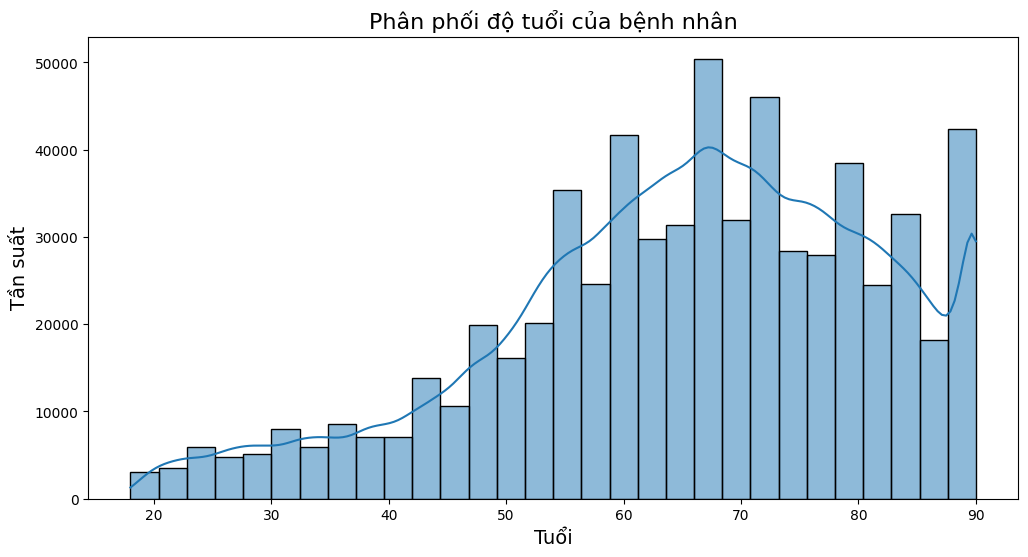

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

#  1.Phân phối độ tuổi của bệnh nhân
plt.figure(figsize=(12, 6))
sns.histplot(filtered_chartevents_df['age'], bins=30, kde=True)
plt.title('Phân phối độ tuổi của bệnh nhân', fontsize = 16)
plt.xlabel('Tuổi', fontsize = 14)
plt.ylabel('Tần suất', fontsize = 14)
plt.show()

## 2.Phân phối giới tính

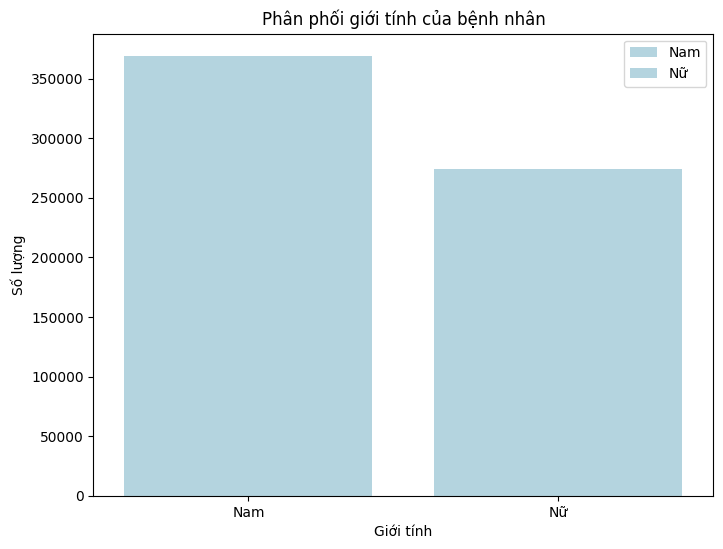

In [16]:
# 2.Phân phối giới tính
plt.figure(figsize=(8, 6))
sns.countplot(data=filtered_chartevents_df, x='gender', order=[0, 1], 
              label=['Nam', 'Nữ'], color='lightblue')
plt.title('Phân phối giới tính của bệnh nhân')
plt.xlabel('Giới tính')
plt.ylabel('Số lượng')
plt.xticks(ticks=[0, 1], labels=['Nam', 'Nữ'])
plt.show()

In [17]:
import pandas as pd
labs_df = pd.read_csv('/kaggle/input/data-icu/labevents.csv',low_memory=True)
labs_df = labs_df[labs_df['subject_id'].isin(subjects)]
labs_df = dataframe_datetime(labs_df)
print(f'{labs_df.shape=}')

labs_df.shape=(54670983, 15)


In [18]:
labs_df.head()

,labevent_id,subject_id,hadm_id,specimen_id,itemid,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
9353,9368,10001217,NaN,17915844,50887,2157-11-18 18:30:00,NaT,HOLD. DISCARD GREATER THAN 24 HRS OLD.,NaN,NaN,NaN,NaN,NaN,STAT,___
9354,9369,10001217,NaN,27706469,51146,2157-11-18 18:30:00,2157-11-18 18:56:00,0.7,0.7,%,0.0,2.0,NaN,STAT,NaN
9355,9370,10001217,NaN,27706469,51200,2157-11-18 18:30:00,2157-11-18 18:56:00,0.5,0.5,%,0.0,4.0,NaN,STAT,NaN
9356,9371,10001217,NaN,27706469,51221,2157-11-18 18:30:00,2157-11-18 18:56:00,42.2,42.2,%,36.0,48.0,NaN,STAT,NaN
9357,9372,10001217,NaN,27706469,51222,2157-11-18 18:30:00,2157-11-18 18:56:00,14.1,14.1,g/dL,12.0,16.0,NaN,STAT,NaN


### labs_df
labevent_id: Mã định danh duy nhất cho mỗi sự kiện xét nghiệm (labevent)

subject_id:Mã định danh của bệnh nhân

hadm_id:Mã định danh của lần nhập viện
specimen_id: Mã định danh của mẫu xét nghiệm
itemid:Mã định danh duy nhất cho từng loại xét nghiệm hoặc chỉ số đo lường. charttime:Thời gian mà xét nghiệm được thực hiện hoặc ghi lại,
storetime:Thời gian mà kết quả xét nghiệm được lưu trữ trong hệ thống
value:Giá trị xét nghiệm dưới dạng văn bản valuenum:Giá trị số của kết quả xét nghiệm
valueuom:Đơn vị đo lường cho giá trị của kết quả xét nghiệm (ví dụ: mg/dL, bpm).
ref_range_lower:Giá trị thấp nhất trong khoảng bình thường cho xét nghiệm
ref_range_upper:Giá trị cao nhất trong khoảng bình thường cho xét nghiệm
flag:Cờ cảnh báo hoặc nhắc nhở về kết quả xét nghiệm
priority: Độ ưu tiên của xét nghiệm
comments:Các chú thích hoặc ghi chú bổ sung về xét nghiệm hoặc kết quả


In [19]:
#  kết hợp hai DataFrame dựa trên các cột chung
filtered_labs_df = pd.merge(
    labs_df,
    icustays_df,
    how='inner',
    left_on=['subject_id', 'hadm_id'],
    right_on=['subject_id', 'hadm_id']
)

filtered_labs_df['charttime'] = pd.to_datetime(filtered_labs_df['charttime'])

# lọc các hàng có charttime nằm trong khoảng thời gian từ intime đến outtime
condition = (filtered_labs_df['charttime'] >= filtered_labs_df['intime']) & (filtered_labs_df['charttime'] <= filtered_labs_df['outtime'])

# chỉ định rằng các hàng thỏa mãn điều kiện sẽ có stay_id được cập nhật
filtered_labs_df.loc[condition, 'stay_id'] = filtered_labs_df.loc[condition, 'stay_id']

# Display the resulting DataFrame
print(filtered_labs_df[['subject_id','hadm_id','stay_id','itemid','valuenum']])
print(f'{filtered_labs_df.shape=}')

          subject_id     hadm_id   stay_id  itemid  valuenum
0           10001217  24597018.0  37067082   51790     59.00
1           10001217  24597018.0  37067082   51802     42.00
2           10001217  24597018.0  37067082   52264    100.00
3           10001217  24597018.0  37067082   52272      0.00
4           10001217  24597018.0  37067082   52281      0.00
...              ...         ...       ...     ...       ...
32210393    19999987  23865745.0  36195440   51250    104.00
32210394    19999987  23865745.0  36195440   51265    129.00
32210395    19999987  23865745.0  36195440   51277     15.40
32210396    19999987  23865745.0  36195440   51279      3.52
32210397    19999987  23865745.0  36195440   51301      5.70

[32210398 rows x 5 columns]
filtered_labs_df.shape=(32210398, 26)


In [20]:
filtered_labs_df.head()

,labevent_id,subject_id,hadm_id,specimen_id,itemid,charttime,storetime,value,valuenum,valueuom,...,first_careunit,last_careunit,intime,outtime,los,age,gender,insurance,admission location,race
0,9427,10001217,24597018.0,69818655,51790,2157-11-19 02:37:00,2157-11-19 03:19:00,59,59.0,mg/dL,...,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,55,1,Other,EMERGENCY ROOM,WHITE
1,9428,10001217,24597018.0,69818655,51802,2157-11-19 02:37:00,2157-11-19 03:19:00,42,42.0,mg/dL,...,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,55,1,Other,EMERGENCY ROOM,WHITE
2,9429,10001217,24597018.0,74137804,52264,2157-11-19 02:37:00,2157-11-19 04:55:00,___,100.0,%,...,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,55,1,Other,EMERGENCY ROOM,WHITE
3,9430,10001217,24597018.0,74137804,52272,2157-11-19 02:37:00,2157-11-19 04:55:00,0,0.0,%,...,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,55,1,Other,EMERGENCY ROOM,WHITE
4,9431,10001217,24597018.0,74137804,52281,2157-11-19 02:37:00,2157-11-19 04:55:00,___,0.0,%,...,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,55,1,Other,EMERGENCY ROOM,WHITE


In [21]:
filtered_labs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32210398 entries, 0 to 32210397
Data columns (total 26 columns):
 #   Column              Dtype         
---  ------              -----         
 0   labevent_id         int64         
 1   subject_id          int64         
 2   hadm_id             float64       
 3   specimen_id         int64         
 4   itemid              int64         
 5   charttime           datetime64[ns]
 6   storetime           datetime64[ns]
 7   value               object        
 8   valuenum            float64       
 9   valueuom            object        
 10  ref_range_lower     float64       
 11  ref_range_upper     float64       
 12  flag                object        
 13  priority            object        
 14  comments            object        
 15  stay_id             int64         
 16  first_careunit      object        
 17  last_careunit       object        
 18  intime              datetime64[ns]
 19  outtime             datetime64[ns]
 20  

In [22]:
filtered_labs_df.describe()

,labevent_id,subject_id,hadm_id,specimen_id,itemid,charttime,storetime,valuenum,ref_range_lower,ref_range_upper,stay_id,intime,outtime,los,age,gender
count,3.221040e+07,3.221040e+07,3.221040e+07,3.221040e+07,3.221040e+07,32210398,32087343,2.935382e+07,2.691885e+07,2.691885e+07,3.221040e+07,32210398,32210398,3.221040e+07,3.221040e+07,3.221040e+07
mean,5.872013e+07,1.497689e+07,2.501746e+07,5.000351e+07,5.111097e+04,2154-02-06 06:54:47.548593152,2154-02-06 11:46:58.669395968,7.338886e+01,3.214410e+01,5.687876e+01,3.498879e+07,2154-02-01 15:43:11.611904,2154-02-09 17:16:18.983236608,8.064669e+00,6.374735e+01,4.109481e-01
min,9.427000e+03,1.000122e+07,2.000015e+07,4.000000e+01,5.080100e+04,2110-01-11 10:22:00,2110-01-11 10:23:00,-1.029000e+03,0.000000e+00,0.000000e+00,3.000015e+07,2110-01-11 10:16:06,2110-01-12 17:17:47,1.000000e+00,1.800000e+01,0.000000e+00
25%,2.893994e+07,1.246268e+07,2.254928e+07,2.499567e+07,5.089300e+04,2133-11-13 06:00:00,2133-11-13 07:44:30,4.000000e+00,3.300000e+00,5.400000e+00,3.249270e+07,2133-11-09 06:45:26,2133-11-12 21:53:47.000000512,2.128148e+00,5.500000e+01,0.000000e+00
50%,5.825580e+07,1.493847e+07,2.505289e+07,5.002524e+07,5.098300e+04,2153-12-13 16:45:00,2153-12-14 04:20:00,1.690000e+01,1.050000e+01,2.000000e+01,3.499608e+07,2153-12-05 12:06:00,2153-12-14 01:07:26,4.070579e+00,6.500000e+01,0.000000e+00
75%,8.825168e+07,1.747075e+07,2.749306e+07,7.500827e+07,5.126500e+04,2174-10-25 08:45:00,2174-10-25 09:19:00,5.190000e+01,3.510000e+01,5.100000e+01,3.745508e+07,2174-10-21 13:00:24,2174-10-23 22:50:47.000000512,9.594005e+00,7.500000e+01,1.000000e+00
max,1.182385e+08,1.999999e+07,2.999983e+07,9.999996e+07,5.314400e+04,2211-11-10 04:51:00,2211-11-10 06:25:00,4.325000e+06,2.200000e+03,1.000000e+05,3.999981e+07,2211-11-09 03:33:00,2211-11-11 18:34:18,1.102323e+02,9.000000e+01,1.000000e+00
std,3.424084e+07,2.894709e+06,2.877977e+06,2.887923e+07,2.941950e+02,NaN,NaN,2.909130e+03,5.364234e+01,5.109456e+02,2.881868e+06,NaN,NaN,1.045270e+01,1.558097e+01,4.920059e-01


In [23]:
# Làm sạch và chuyển đổi cột 'giá trị' thành số
filtered_labs_df['value'] = pd.to_numeric(filtered_labs_df['value'], errors='coerce')

# Kiểm tra trùng lặp trong cot 'stay_id', 'itemid'
duplicates_for_stay_id = filtered_labs_df[filtered_labs_df.duplicated(subset=['stay_id', 'itemid'], keep=False)]

# Tính giá trị trung bình cho itemid, stay_id trùng lặp trong mỗi nhóm stay_id
averages_for_duplicates = duplicates_for_stay_id.groupby(['stay_id', 'itemid'])['value'].mean().reset_index()

# Gộp các giá trị trung bình đã tính toán trở lại DataFrame gốc
filtered_labs_df = pd.merge(filtered_labs_df, averages_for_duplicates, how='left', on=['stay_id', 'itemid'], suffixes=('', '_avg'))

# Điền giá trị NaN vào cột 'giá trị' ban đầu bằng giá trị trung bình đã tính toán
filtered_labs_df['value'].fillna(filtered_labs_df['value_avg'], inplace=True)

# Xóa cột 'value_avg' thừa
filtered_labs_df.drop(columns=['value_avg'], inplace=True)

/tmp/ipykernel_13/3213748601.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_labs_df['value'].fillna(filtered_labs_df['value_avg'], inplace=True)


In [24]:
import pandas as pd
pharm_df = pd.read_csv('/kaggle/input/data-icu/prescriptions.csv',low_memory=True)


filtered_pharm_df = pd.merge(
    pharm_df,
    icustays_df,
    how='inner',
    left_on=['subject_id', 'hadm_id'],
    right_on=['subject_id', 'hadm_id']
)

filtered_pharm_df['starttime'] = pd.to_datetime(filtered_pharm_df['starttime'])


condition = (filtered_pharm_df['starttime'] >= filtered_pharm_df['intime']) & (filtered_pharm_df['starttime'] <= filtered_pharm_df['outtime'])
filtered_pharm_df.loc[condition, 'stay_id'] = filtered_pharm_df.loc[condition, 'stay_id']


print(filtered_pharm_df[['subject_id','hadm_id','stay_id','drug']])
print(f'{filtered_pharm_df.shape=}')

         subject_id   hadm_id   stay_id                         drug
0          10001217  24597018  37067082  Sodium Chloride 0.9%  Flush
1          10001217  24597018  37067082         0.9% Sodium Chloride
2          10001217  24597018  37067082                LeVETiracetam
3          10001217  24597018  37067082                  HydrALAzine
4          10001217  24597018  37067082                 Lidocaine 1%
...             ...       ...       ...                          ...
6935981    19999987  23865745  36195440      Influenza Virus Vaccine
6935982    19999987  23865745  36195440         Levothyroxine Sodium
6935983    19999987  23865745  36195440                   Duloxetine
6935984    19999987  23865745  36195440               Venlafaxine XR
6935985    19999987  23865745  36195440                   Duloxetine

[6935986 rows x 4 columns]
filtered_pharm_df.shape=(6935986, 31)


In [25]:
filtered_pharm_df.head()

,subject_id,hadm_id,pharmacy_id,poe_id,poe_seq,starttime,stoptime,drug_type,drug,formulary_drug_cd,...,first_careunit,last_careunit,intime,outtime,los,age,gender,insurance,admission location,race
0,10001217,24597018,1314750,10001217-117,117.0,2157-11-19 01:00:00,2157-11-25 22:00:00,MAIN,Sodium Chloride 0.9% Flush,NACLFLUSH,...,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,55,1,Other,EMERGENCY ROOM,WHITE
1,10001217,24597018,1724826,10001217-65,65.0,2157-11-19 20:00:00,2157-11-20 19:00:00,BASE,0.9% Sodium Chloride,NS1000ML,...,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,55,1,Other,EMERGENCY ROOM,WHITE
2,10001217,24597018,11409686,10001217-123,123.0,2157-11-19 14:00:00,2157-11-25 22:00:00,MAIN,LeVETiracetam,LEVE500,...,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,55,1,Other,EMERGENCY ROOM,WHITE
3,10001217,24597018,13271194,10001217-101,101.0,2157-11-20 13:00:00,2157-11-21 12:00:00,MAIN,HydrALAzine,HYDZ20I,...,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,55,1,Other,EMERGENCY ROOM,WHITE
4,10001217,24597018,13426851,10001217-51,51.0,2157-11-19 01:00:00,2157-11-20 00:00:00,MAIN,Lidocaine 1%,LIDPF1I,...,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,55,1,Other,EMERGENCY ROOM,WHITE


In [26]:
filtered_pharm_df.describe()

,subject_id,hadm_id,pharmacy_id,poe_seq,starttime,ndc,doses_per_24_hrs,stay_id,intime,outtime,los,age,gender
count,6.935986e+06,6.935986e+06,6.935986e+06,6.841774e+06,6925040,6.928254e+06,3.982807e+06,6.935986e+06,6935986,6935986,6.935986e+06,6.935986e+06,6.935986e+06
mean,1.497812e+07,2.501067e+07,5.000608e+07,7.986881e+02,2154-03-10 10:09:32.034357248,1.626698e+10,1.555700e+00,3.497946e+07,2154-03-07 03:53:58.436119552,2154-03-13 19:34:46.941579264,6.653339e+00,6.419156e+01,4.171469e-01
min,1.000122e+07,2.000015e+07,1.200000e+01,2.000000e+00,2110-01-11 08:00:00,0.000000e+00,0.000000e+00,3.000015e+07,2110-01-11 10:16:06,2110-01-12 17:17:47,1.000000e+00,1.800000e+01,0.000000e+00
25%,1.246521e+07,2.253429e+07,2.498626e+07,1.760000e+02,2134-01-22 12:00:00,1.210431e+08,1.000000e+00,3.248336e+07,2134-01-19 16:06:00,2134-01-26 17:20:32,1.930486e+00,5.500000e+01,0.000000e+00
50%,1.495339e+07,2.503841e+07,5.001241e+07,4.060000e+02,2154-01-16 06:00:00,4.094902e+08,1.000000e+00,3.497147e+07,2154-01-11 23:38:00,2154-01-21 04:07:11.000000512,3.415301e+00,6.600000e+01,0.000000e+00
75%,1.747797e+07,2.748972e+07,7.501305e+07,9.410000e+02,2174-09-03 08:00:00,4.382501e+10,2.000000e+00,3.745858e+07,2174-09-01 20:50:51.000000512,2174-09-06 14:49:44.999999488,7.561068e+00,7.600000e+01,1.000000e+00
max,1.999999e+07,2.999983e+07,9.999998e+07,2.007800e+04,2211-11-12 08:00:00,9.277106e+10,7.000000e+01,3.999981e+07,2211-11-09 03:33:00,2211-11-11 18:34:18,1.102323e+02,9.000000e+01,1.000000e+00
std,2.892206e+06,2.878608e+06,2.887375e+07,1.130601e+03,NaN,2.595441e+10,1.121084e+00,2.882927e+06,NaN,NaN,8.790359e+00,1.555351e+01,4.930876e-01


In [27]:
filtered_pharm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6935986 entries, 0 to 6935985
Data columns (total 31 columns):
 #   Column              Dtype         
---  ------              -----         
 0   subject_id          int64         
 1   hadm_id             int64         
 2   pharmacy_id         int64         
 3   poe_id              object        
 4   poe_seq             float64       
 5   starttime           datetime64[ns]
 6   stoptime            object        
 7   drug_type           object        
 8   drug                object        
 9   formulary_drug_cd   object        
 10  gsn                 object        
 11  ndc                 float64       
 12  prod_strength       object        
 13  form_rx             object        
 14  dose_val_rx         object        
 15  dose_unit_rx        object        
 16  form_val_disp       object        
 17  form_unit_disp      object        
 18  doses_per_24_hrs    float64       
 19  route               object        
 20  st

In [28]:
# Tạo khung dữ liệu để phân tích
analysis_chartevents_df = filtered_chartevents_df[['stay_id', 'subject_id', 'itemid', 'valuenum','insurance','gender','age','race']]
analysis_labs_df = filtered_labs_df[['subject_id', 'stay_id', 'itemid', 'value','insurance','gender','age','race']]
analysis_pharm_df = filtered_pharm_df[['subject_id', 'stay_id', 'drug','insurance','gender','age','race']]

analysis_chartevents_df

,stay_id,subject_id,itemid,valuenum,insurance,gender,age,race
0,30000153,12466550,220045,100.0,Other,0,61,WHITE
1,30000153,12466550,220048,NaN,Other,0,61,WHITE
2,30000153,12466550,220050,151.0,Other,0,61,WHITE
3,30000153,12466550,220051,72.0,Other,0,61,WHITE
4,30000153,12466550,220052,80.0,Other,0,61,WHITE
...,...,...,...,...,...,...,...,...
643354,39999810,17840864,220180,81.0,Other,0,55,WHITE
643355,39999810,17840864,220181,98.0,Other,0,55,WHITE
643356,39999810,17840864,223761,98.1,Other,0,55,WHITE
643357,39999810,17840864,224642,NaN,Other,0,55,WHITE


In [29]:
analysis_chartevents_df.info

<bound method DataFrame.info of          stay_id  subject_id  itemid  valuenum insurance  gender  age   race
0       30000153    12466550  220045     100.0     Other       0   61  WHITE
1       30000153    12466550  220048       NaN     Other       0   61  WHITE
2       30000153    12466550  220050     151.0     Other       0   61  WHITE
3       30000153    12466550  220051      72.0     Other       0   61  WHITE
4       30000153    12466550  220052      80.0     Other       0   61  WHITE
...          ...         ...     ...       ...       ...     ...  ...    ...
643354  39999810    17840864  220180      81.0     Other       0   55  WHITE
643355  39999810    17840864  220181      98.0     Other       0   55  WHITE
643356  39999810    17840864  223761      98.1     Other       0   55  WHITE
643357  39999810    17840864  224642       NaN     Other       0   55  WHITE
643358  39999810    17840864  224650       NaN     Other       0   55  WHITE

[643359 rows x 8 columns]>

In [30]:
analysis_chartevents_df.describe()

,stay_id,subject_id,itemid,valuenum,gender,age
count,6.433590e+05,6.433590e+05,643359.000000,4.265610e+05,643359.000000,643359.000000
mean,3.498661e+07,1.499898e+07,222236.342563,1.083525e+02,0.426224,65.007863
std,2.887588e+06,2.893029e+06,2574.433325,1.531676e+04,0.494528,16.108361
min,3.000015e+07,1.000122e+07,220045.000000,-1.350000e+02,0.000000,18.000000
25%,3.248674e+07,1.248956e+07,220051.000000,6.300000e+01,0.000000,55.000000
50%,3.497961e+07,1.499418e+07,220181.000000,8.600000e+01,0.000000,67.000000
75%,3.748849e+07,1.752136e+07,224642.000000,1.001000e+02,1.000000,77.000000
max,3.999981e+07,1.999999e+07,229863.000000,1.000000e+07,1.000000,90.000000


In [31]:
analysis_labs_df.head()

,subject_id,stay_id,itemid,value,insurance,gender,age,race
0,10001217,37067082,51790,59.0,Other,1,55,WHITE
1,10001217,37067082,51802,42.0,Other,1,55,WHITE
2,10001217,37067082,52264,NaN,Other,1,55,WHITE
3,10001217,37067082,52272,0.0,Other,1,55,WHITE
4,10001217,37067082,52281,NaN,Other,1,55,WHITE


In [32]:
analysis_labs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32210398 entries, 0 to 32210397
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   subject_id  int64  
 1   stay_id     int64  
 2   itemid      int64  
 3   value       float64
 4   insurance   object 
 5   gender      int64  
 6   age         int64  
 7   race        object 
dtypes: float64(1), int64(5), object(2)
memory usage: 1.9+ GB


In [33]:
analysis_labs_df.describe()

,subject_id,stay_id,itemid,value,gender,age
count,3.221040e+07,3.221040e+07,3.221040e+07,2.796768e+07,3.221040e+07,3.221040e+07
mean,1.497689e+07,3.498879e+07,5.111097e+04,6.206071e+01,4.109481e-01,6.374735e+01
std,2.894709e+06,2.881868e+06,2.941950e+02,2.872317e+03,4.920059e-01,1.558097e+01
min,1.000122e+07,3.000015e+07,5.080100e+04,-1.029000e+03,0.000000e+00,1.800000e+01
25%,1.246268e+07,3.249270e+07,5.089300e+04,3.900000e+00,0.000000e+00,5.500000e+01
50%,1.493847e+07,3.499608e+07,5.098300e+04,1.580000e+01,0.000000e+00,6.500000e+01
75%,1.747075e+07,3.745508e+07,5.126500e+04,4.200000e+01,1.000000e+00,7.500000e+01
max,1.999999e+07,3.999981e+07,5.314400e+04,4.325000e+06,1.000000e+00,9.000000e+01


In [34]:
analysis_pharm_df.head()

,subject_id,stay_id,drug,insurance,gender,age,race
0,10001217,37067082,Sodium Chloride 0.9% Flush,Other,1,55,WHITE
1,10001217,37067082,0.9% Sodium Chloride,Other,1,55,WHITE
2,10001217,37067082,LeVETiracetam,Other,1,55,WHITE
3,10001217,37067082,HydrALAzine,Other,1,55,WHITE
4,10001217,37067082,Lidocaine 1%,Other,1,55,WHITE


In [35]:
analysis_pharm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6935986 entries, 0 to 6935985
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   subject_id  int64 
 1   stay_id     int64 
 2   drug        object
 3   insurance   object
 4   gender      int64 
 5   age         int64 
 6   race        object
dtypes: int64(4), object(3)
memory usage: 370.4+ MB


In [36]:
analysis_pharm_df.describe()

,subject_id,stay_id,gender,age
count,6.935986e+06,6.935986e+06,6.935986e+06,6.935986e+06
mean,1.497812e+07,3.497946e+07,4.171469e-01,6.419156e+01
std,2.892206e+06,2.882927e+06,4.930876e-01,1.555351e+01
min,1.000122e+07,3.000015e+07,0.000000e+00,1.800000e+01
25%,1.246521e+07,3.248336e+07,0.000000e+00,5.500000e+01
50%,1.495339e+07,3.497147e+07,0.000000e+00,6.600000e+01
75%,1.747797e+07,3.745858e+07,1.000000e+00,7.600000e+01
max,1.999999e+07,3.999981e+07,1.000000e+00,9.000000e+01


In [37]:
# Chỉ giữ lại các cột cần thiết cho mỗi khung dữ liệu
_chartevents_df = filtered_chartevents_df[['stay_id', 'subject_id', 'itemid', 'valuenum']]
_labs_df = filtered_labs_df[['subject_id', 'stay_id', 'itemid', 'value']]
_pharm_df = filtered_pharm_df[['subject_id', 'stay_id', 'drug']]

In [38]:
# Thay thế các giá trị item_id bằng tên để dễ đọc hơn

d_items = pd.read_csv('/kaggle/input/data-icu/d_items.csv',low_memory=True)

d_items.head()

# Tạo một từ điển ánh xạ itemid, label từ chartevent_definitions
itemid_to_label = d_items.set_index('itemid')['label'].to_dict()


# thay thế mỗi giá trị itemid bằng giá trị tương ứng trong từ điển
_chartevents_df['itemid'] = _chartevents_df['itemid'].map(itemid_to_label)


d_labitems = pd.read_csv('/kaggle/input/data-icu/d_labitems.csv',low_memory=True)

# Tạo một từ điển ánh xạ itemid, label từ d_labitems
itemid_to_label = d_labitems.set_index('itemid')['label'].to_dict()


# thay thế mỗi giá trị itemid bằng giá trị tương ứng trong từ điển
_labs_df['itemid'] = _labs_df['itemid'].map(itemid_to_label)

/tmp/ipykernel_13/1495255424.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _chartevents_df['itemid'] = _chartevents_df['itemid'].map(itemid_to_label)
/tmp/ipykernel_13/1495255424.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _labs_df['itemid'] = _labs_df['itemid'].map(itemid_to_label)


In [39]:
import pandas as pd

# Chuyển đổi cột 'valuenum' thành số, ép buộc các giá trị không phải số thành NaN
_chartevents_df['valuenum'] = pd.to_numeric(_chartevents_df['valuenum'], errors='coerce')

# Pivot DataFrame mà không có itemid ->  tạo ra một bảng tóm tắt
final_chartevents = _chartevents_df.pivot_table(
    index=['subject_id', 'stay_id'],
    columns='itemid',
    values='valuenum'
)

# Lặp lại các cột có giá trị bị thiếu và điền giá trị trung vi của mỗi 'itemid'
for col in final_chartevents.columns:
    median_value = final_chartevents[col].median()
    final_chartevents[col].fillna(median_value, inplace=True)


final_chartevents = final_chartevents.reset_index()


/tmp/ipykernel_13/1367592205.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _chartevents_df['valuenum'] = pd.to_numeric(_chartevents_df['valuenum'], errors='coerce')
/tmp/ipykernel_13/1367592205.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_chartevents[col].fillna(media

In [40]:
import pandas as pd

# Chuyển đổi cột 'giá trị' thành số, ép buộc các giá trị không phải số thành NaN
_labs_df['value'] = pd.to_numeric(_labs_df['value'], errors='coerce')

# Pivot DataFrame mà không có itemid ->  tạo ra một bảng tóm tắt
final_labs = _labs_df.pivot_table(
    index=['subject_id', 'stay_id'],
    columns='itemid',
    values='value'
)

# Lặp lại các cột có giá trị bị thiếu và điền giá trị trung vi của mỗi 'itemid'
for col in final_labs.columns:
    median_value = final_labs[col].median()
    final_labs[col].fillna(median_value, inplace=True)

# Reset the index if needed
final_labs = final_labs.reset_index()


/tmp/ipykernel_13/2824756265.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _labs_df['value'] = pd.to_numeric(_labs_df['value'], errors='coerce')
/tmp/ipykernel_13/2824756265.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_labs[col].fillna(median_value, inplace=True)
/tmp

In [41]:
# Tạo một cột mới 'giá trị' và đặt nó thành 1 cho tất cả các hàng
# thêm biến giả -> đánh dấu rằng một hàng tồn tại trong DataFrame
_pharm_df['value'] = 1

# Pivot 
final_pharm = _pharm_df.pivot_table(index=['subject_id', 'stay_id'], columns='drug', values='value', fill_value=0)


final_pharm = final_pharm.reset_index()
final_pharm.head(5)

/tmp/ipykernel_13/2343960675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _pharm_df['value'] = 1


drug,subject_id,stay_id,CoQ10 (300mg),L-Citrulline,Symbicort,ketamine 5%/ lidocaine 5% / amit 2%,(0.9% NaCl),*NF* Abatacept,*NF* Allopurinol Sodium,*NF* Arginine HCl,...,zafirlukast,zanamivir,zeas,zileuton,zinc oxide,zinc oxide-white petrolatum,zolmitriptan,zonisamide,zydis,zz
0,10001217,37067082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10001725,31205490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10001884,37510196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10002013,39060235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10002155,31090461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Hợp nhất hai DataFrames đầu tiên 
icu_data = pd.merge(icustays_df, final_chartevents, on=['subject_id', 'stay_id'], how='inner')

# Hợp nhất 3  pivoted DataFrame
icu_data = pd.merge(icu_data, final_labs, on=['subject_id', 'stay_id'], how='inner')

#hợp nhất icustays_df DataFrame
icu_data = pd.merge(icu_data, final_pharm, on=['subject_id', 'stay_id'], how='inner')


icu_data.head(5)

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,age,gender,...,zafirlukast,zanamivir,zeas,zileuton,zinc oxide,zinc oxide-white petrolatum,zolmitriptan,zonisamide,zydis,zz
0,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,55,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,46,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10001884,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,77,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10002013,23581541,39060235,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,57,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10002155,23822395,33685454,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2129-08-04 12:45:00,2129-08-10 17:02:38,6.178912,81,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
print(icu_data['stay_id'].nunique())

57487


In [44]:
# Từ điển bản đồ để đổi tên chủng tộc
race_mapping = {
    'ASIAN - ASIAN INDIAN': 'ASIAN',
    'ASIAN - CHINESE': 'ASIAN',
    'ASIAN - KOREAN': 'ASIAN',
    'ASIAN - SOUTH EAST ASIAN': 'ASIAN',
    'UNKNOWN': 'OTHER',
    'UNABLE TO OBTAIN': 'OTHER',
    'PATIENT DECLINED TO ANSWER': 'OTHER',
    'WHITE - RUSSIAN': 'WHITE',
    'PORTUGUESE': 'WHITE',
    'WHITE - BRAZILIAN': 'WHITE',
    'WHITE - OTHER EUROPEAN': 'WHITE',
    'WHITE - EASTERN EUROPEAN': 'WHITE', 
    'BLACK/CAPE VERDEAN':'BLACK/AFRICAN AMERICAN',
    'BLACK/AFRICAN':'BLACK/AFRICAN AMERICAN',
    'BLACK/CARIBBEAN ISLAND':'BLACK/AFRICAN AMERICAN',
    'HISPANIC/LATINO - CUBAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - PUERTO RICAN': 'HISPANIC/LATINO',
    'HISPANIC OR LATINO': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - SALVADORAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - DOMINICAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - HONDURAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - COLUMBIAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - GUATEMALAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - MEXICAN': 'HISPANIC/LATINO',
    'SOUTH AMERICAN': 'HISPANIC/LATINO',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'PACIFIC ISLANDER',
    'AMERICAN INDIAN/ALASKA NATIVE': 'PACIFIC ISLANDER',
    'NATIVE HAWAIIAN/PACIFIC ISLANDER': 'PACIFIC ISLANDER'
    
}

# Thay thế các giá trị trong cột 'race' bằng cách sử dụng từ điển ánh xạ cho tất cả các khung dữ liệu
icu_data['race'] = icu_data['race'].replace(race_mapping)
analysis_chartevents_df['race'] = analysis_chartevents_df['race'].replace(race_mapping)
analysis_labs_df['race'] = analysis_labs_df['race'].replace(race_mapping)
analysis_pharm_df['race'] = analysis_pharm_df['race'].replace(race_mapping)

# Hiển thị DataFrame đã cập nhật
print(analysis_chartevents_df['race'].unique().tolist())
print(analysis_labs_df['race'].unique().tolist())
print(analysis_pharm_df['race'].unique().tolist())

/tmp/ipykernel_13/104047732.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_chartevents_df['race'] = analysis_chartevents_df['race'].replace(race_mapping)
/tmp/ipykernel_13/104047732.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_labs_df['race'] = analysis_labs_df['race'].replace(race_mapping)
/tmp/ipykernel_13/104047732.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

['WHITE', 'HISPANIC/LATINO', 'ASIAN', 'OTHER', 'BLACK/AFRICAN AMERICAN', 'PACIFIC ISLANDER', 'MULTIPLE RACE/ETHNICITY']
['WHITE', 'BLACK/AFRICAN AMERICAN', 'OTHER', 'HISPANIC/LATINO', 'ASIAN', 'PACIFIC ISLANDER', 'MULTIPLE RACE/ETHNICITY']
['WHITE', 'BLACK/AFRICAN AMERICAN', 'OTHER', 'HISPANIC/LATINO', 'ASIAN', 'PACIFIC ISLANDER', 'MULTIPLE RACE/ETHNICITY']


In [45]:

print(icu_data.shape[0])
print(icu_data.shape[1])

57487
5074


In [46]:
icu_data.to_csv('icu_data_Median.csv', index=False)

# Dataset Stadistics

In [47]:
import pandas as pd

icu_data = pd.read_csv('icu_data_Median.csv',low_memory=True)
icu_stays = pd.read_csv('/kaggle/input/data-icu/icustays.csv', low_memory=True)
admissions = pd.read_csv('/kaggle/input/data-icu/admissions.csv',low_memory=True)
patients = pd.read_csv('/kaggle/input/data-icu/patients.csv', low_memory=True)


In [48]:
icu_data.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,age,gender,...,zafirlukast,zanamivir,zeas,zileuton,zinc oxide,zinc oxide-white petrolatum,zolmitriptan,zonisamide,zydis,zz
0,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,55,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,46,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10001884,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,77,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10002013,23581541,39060235,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,57,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10002155,23822395,33685454,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2129-08-04 12:45:00,2129-08-10 17:02:38,6.178912,81,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
icu_data.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los', 'age', 'gender',
       ...
       'zafirlukast', 'zanamivir', 'zeas', 'zileuton', 'zinc oxide',
       'zinc oxide-white petrolatum', 'zolmitriptan', 'zonisamide', 'zydis',
       'zz'],
      dtype='object', length=5074)

In [50]:
icu_data.describe()

,subject_id,hadm_id,stay_id,los,age,gender,ART BP Diastolic,ART BP Mean,ART BP Systolic,Arctic Sun/Alsius Temp #1 C,...,zafirlukast,zanamivir,zeas,zileuton,zinc oxide,zinc oxide-white petrolatum,zolmitriptan,zonisamide,zydis,zz
count,5.748700e+04,5.748700e+04,5.748700e+04,57487.000000,57487.000000,57487.000000,57487.000000,57487.000000,57487.000000,57487.000000,...,57487.000000,57487.000000,57487.000000,57487.000000,57487.000000,57487.000000,57487.000000,57487.000000,57487.000000,57487.000000
mean,1.500135e+07,2.498608e+07,3.498641e+07,4.196408,64.980778,0.434724,58.126620,78.064154,114.232592,35.799192,...,0.000174,0.000035,0.000017,0.000035,0.000313,0.000035,0.000035,0.000017,0.000017,0.000052
std,2.891885e+06,2.884737e+06,2.886424e+06,5.323901,16.317389,0.495725,4.668791,11.801663,8.117540,0.367498,...,0.013188,0.005898,0.004171,0.005898,0.017692,0.005898,0.005898,0.004171,0.004171,0.007224
min,1.000122e+07,2.000015e+07,3.000015e+07,1.000000,18.000000,0.000000,-40.000000,-39.000000,-4.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.249356e+07,2.249296e+07,3.248734e+07,1.570804,55.000000,0.000000,58.000000,78.000000,114.000000,35.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.499722e+07,2.497799e+07,3.497843e+07,2.412164,67.000000,0.000000,58.000000,78.000000,114.000000,35.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.752197e+07,2.747477e+07,3.747962e+07,4.434288,77.000000,1.000000,58.000000,78.000000,114.000000,35.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.999999e+07,2.999983e+07,3.999981e+07,110.232280,90.000000,1.000000,332.000000,951.000000,336.000000,98.500000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:

# Hàm trả về phần trăm tùy thuộc vào một cột và điều kiện cụ thể

def percentage(df, column, condition):

    condition_number = len(df.loc[df[column]==condition])
    result = condition_number / len(df)
    
    return result

In [52]:
icu_stays.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los'],
      dtype='object')

In [53]:
 # lấy các giá trị duy nhất từ cột insurance
admissions['insurance'].unique()

array(['Other', 'Medicaid', 'Medicare'], dtype=object)

In [54]:
# tỷ lệ phần trăm của hàng Other 
result = percentage(admissions, 'insurance', 'Other')
print(result)

0.5320676984745574


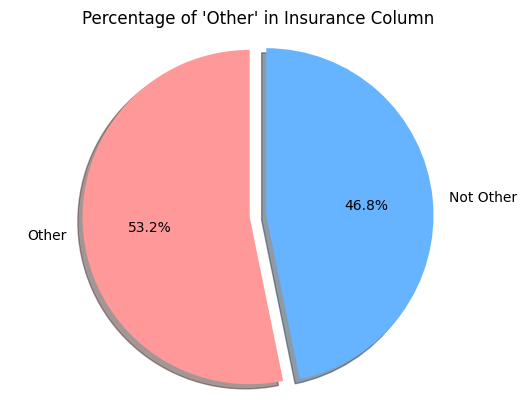

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['Other', 'Not Other']
sizes = [result * 100, (1 - result) * 100]
colors = ['#ff9999','#66b3ff']
explode = (0.1,0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Tỷ lệ khung hình bằng nhau đảm bảo rằng hình tròn được vẽ theo dạng hình tròn.
plt.title("Percentage of 'Other' in Insurance Column")
plt.show()

In [56]:
icu_data['hadm_id'].nunique()

52781

In [57]:
icu_stays['hadm_id'].loc[icu_stays['los']>1].nunique()

52988

In [58]:
len(icu_data[icu_data['age'] >= 18])

57487

In [59]:
result = len(icu_data[icu_data['los'] > 4])
print(result)

16475


In [60]:
analysis_labs_df.head(1)

,subject_id,stay_id,itemid,value,insurance,gender,age,race
0,10001217,37067082,51790,59.0,Other,1,55,WHITE


# Data Visualizations for Disparities in Data

## Fig. 1: Depiction of Race breakdown -  - Miêu tả sự phân chia chủng tộc

###  (a) Average number of medications per ICU stay - Số lượng thuốc trung bình cho mỗi lần nằm ICU

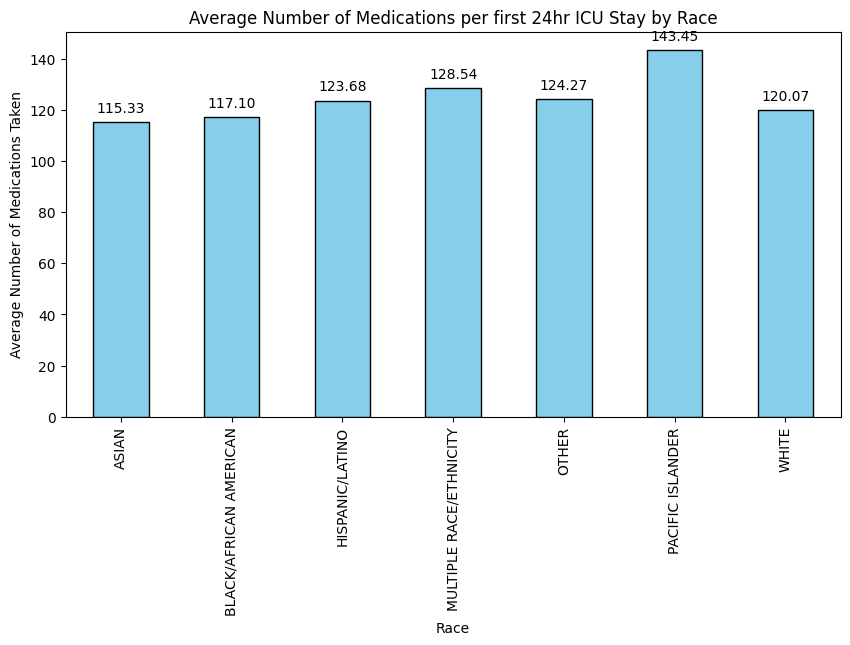

In [61]:
import matplotlib.pyplot as plt


# # Nhóm theo 'stay_id' và 'race' -> đếm số lượng sự kiện trong mỗi nhóm và lưu kết quả vào cột pharm_count
average_pharm = analysis_pharm_df.groupby(['stay_id', 'race']).size().reset_index(name='pharm_count').groupby('race')['pharm_count'].mean()

# Vẽ biểu đồ thanh(bar chart)
ax = average_pharm.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10,5))

# thêm nhãn vào thanh
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Medications per first 24hr ICU Stay by Race')
plt.xlabel('Race')
plt.ylabel('Average Number of Medications Taken')
plt.show()

### (b) average number of labs per ICU stay - Số lượng xét nghiệm trung bình cho mỗi lần nằm ICU

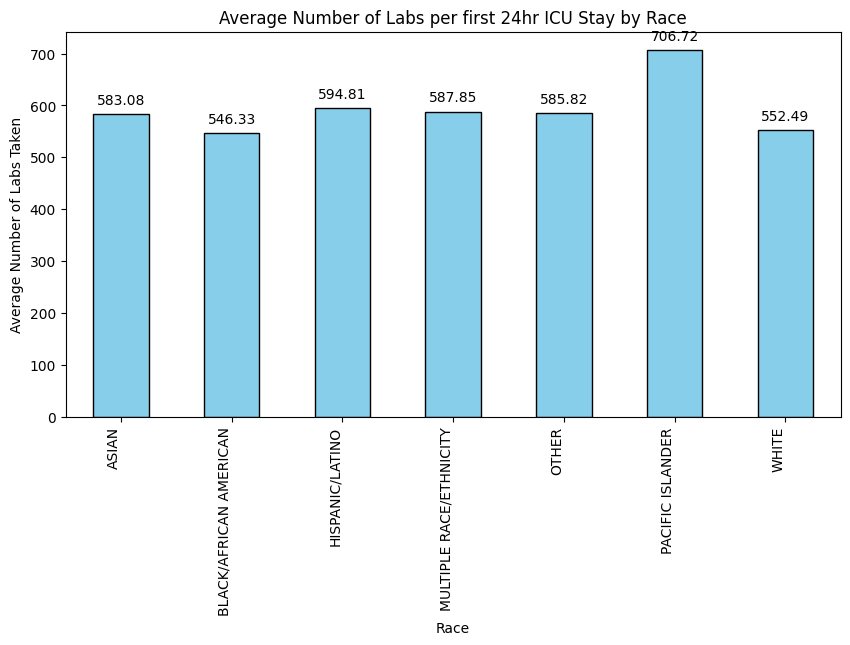

In [62]:
# analysis_labs_df

# Nhóm theo 'stay_id' và 'race' -> đếm số lượng sự kiện trong mỗi nhóm và lưu kết quả vào cột labs_count
average_labs = analysis_labs_df.groupby(['stay_id', 'race']).size().reset_index(name='labs_count').groupby('race')['labs_count'].mean()

# Vẽ biểu đồ thanh - bar chart
ax = average_labs.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10,5))

# thêm labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Labs per first 24hr ICU Stay by Race')
plt.xlabel('Race')
plt.ylabel('Average Number of Labs Taken')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

### (c) average number of vitals per ICU stay - số lượng trung bình các dấu hiệu sinh tồn trong mỗi lần nằm ICU

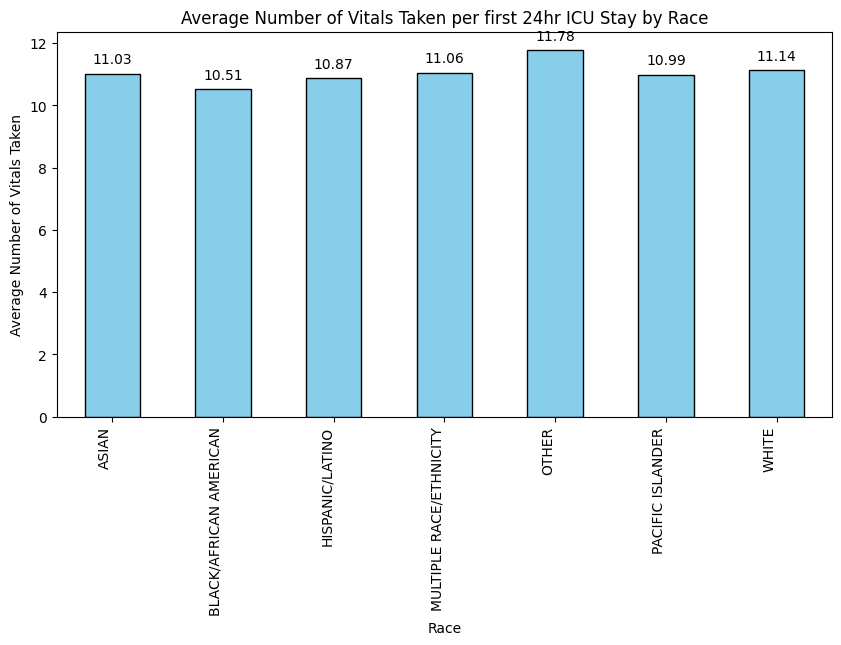

In [63]:
# Nhóm theo 'stay_id' và 'race' -> đếm số lượng sự kiện trong mỗi nhóm và lưu kết quả vào cột chartevents_count
average_chartevents = analysis_chartevents_df.groupby(['stay_id', 'race']).size().reset_index(name='chartevents_count').groupby('race')['chartevents_count'].mean()

# Vẽ biểu đồ thanh - bar chart
ax = average_chartevents.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10,5))

# thêm labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Vitals Taken per first 24hr ICU Stay by Race')
plt.xlabel('Race')
plt.ylabel('Average Number of Vitals Taken')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

##  Fig. 2: Depiction of gender breakdown - - Miêu tả sự phân chia giới tính.

###  (a) The average number of medications per ICU stay -  Số lượng thuốc trung bình cho mỗi lần nằm ICU

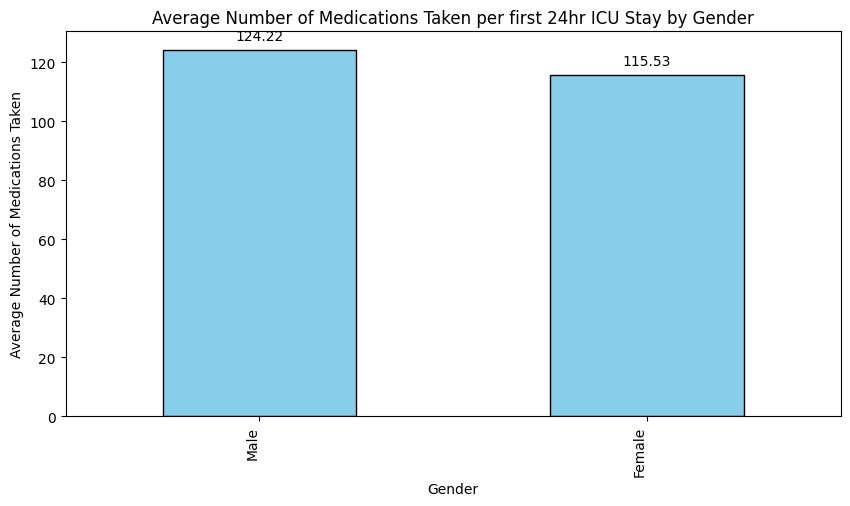

In [64]:


# Nhóm theo 'stay_id' và 'gender' -> đếm số lượng sự kiện trong mỗi nhóm và lưu kết quả vào cột pharm_count
average_pharm = analysis_pharm_df.groupby(['stay_id', 'gender']).size().reset_index(name='pharm_count').groupby('gender')['pharm_count'].mean()

# Biểu đồ thanh - bar chart
ax = average_pharm.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10,5))

# thêm labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Medications Taken per first 24hr ICU Stay by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Number of Medications Taken')
ax.set_xticklabels(['Male', 'Female'], rotation=90, ha='right')
plt.show()

### (b) the average number of labs per ICU stay - - số lượng xét nghiệm trung bình cho mỗi lần nằm ICU

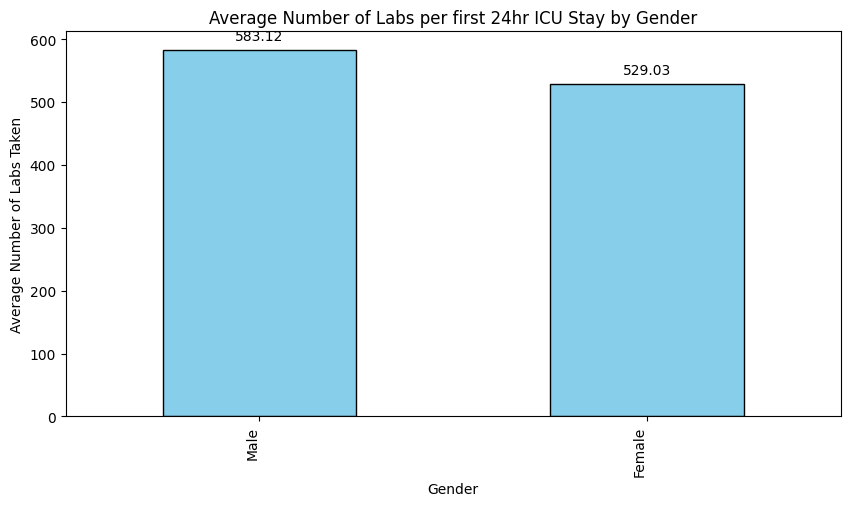

In [65]:
# Nhóm theo 'stay_id' và 'gender' -> đếm số lượng sự kiện trong mỗi nhóm và lưu kết quả vào cột labs_count
average_labs = analysis_labs_df.groupby(['stay_id', 'gender']).size().reset_index(name='labs_count').groupby('gender')['labs_count'].mean()

#  Biểu đồ bar chart
ax = average_labs.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10, 5))

# thêm nhãn
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Labs per first 24hr ICU Stay by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Number of Labs Taken')


ax.set_xticklabels(['Male', 'Female'], rotation=90, ha='right')

plt.show()

### (c) the average number of vitals per ICU stay - số lượng dấu hiệu sinh tồn trung bình trong mỗi lần nằm ICU

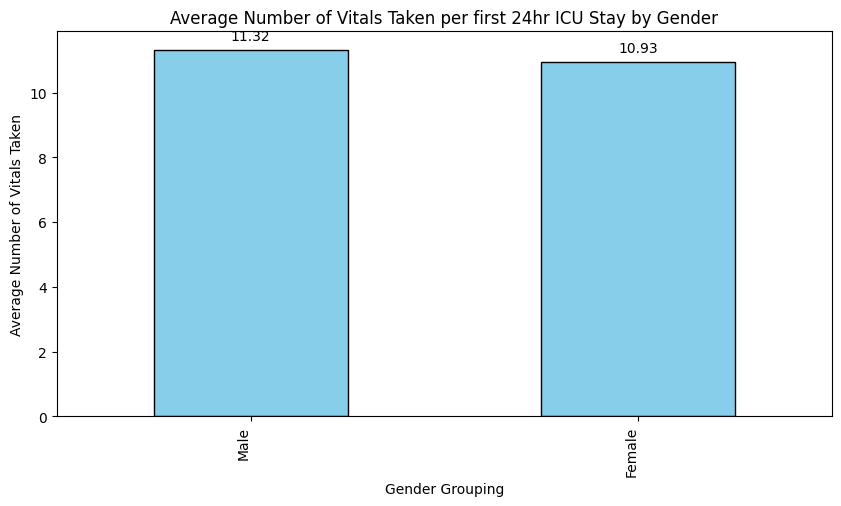

In [66]:
# Nhóm theo 'stay_id' và 'gender' -> đếm số lượng sự kiện trong mỗi nhóm và lưu kết quả vào cột chartevents_count
average_chartevents = analysis_chartevents_df.groupby(['stay_id', 'gender']).size().reset_index(name='chartevents_count').groupby('gender')['chartevents_count'].mean()

# Biểu đồ thanh
ax = average_chartevents.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10,5))

# thêm labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Vitals Taken per first 24hr ICU Stay by Gender')
plt.xlabel('Gender Grouping')
plt.ylabel('Average Number of Vitals Taken')
ax.set_xticklabels(['Male', 'Female'], rotation=90, ha='right')
plt.show()

##  Fig. 3: Depiction of insurance breakdown - Miêu tả về sự cố bảo hiểm

### (a) Average number of medications per ICU stay - Số lượng thuốc trung bình cho mỗi lần nằm ICU

In [67]:
analysis_chartevents_df

,stay_id,subject_id,itemid,valuenum,insurance,gender,age,race
0,30000153,12466550,220045,100.0,Other,0,61,WHITE
1,30000153,12466550,220048,NaN,Other,0,61,WHITE
2,30000153,12466550,220050,151.0,Other,0,61,WHITE
3,30000153,12466550,220051,72.0,Other,0,61,WHITE
4,30000153,12466550,220052,80.0,Other,0,61,WHITE
...,...,...,...,...,...,...,...,...
643354,39999810,17840864,220180,81.0,Other,0,55,WHITE
643355,39999810,17840864,220181,98.0,Other,0,55,WHITE
643356,39999810,17840864,223761,98.1,Other,0,55,WHITE
643357,39999810,17840864,224642,NaN,Other,0,55,WHITE


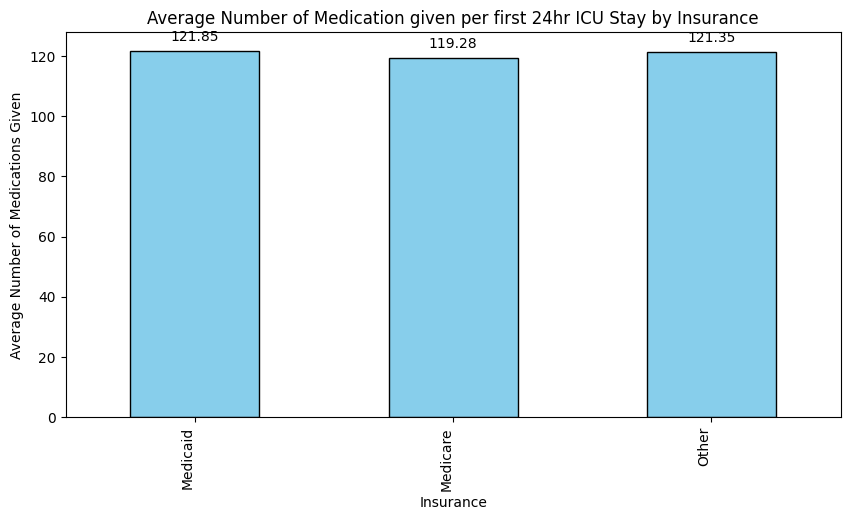

In [68]:

# Nhóm theo 'stay_id' và 'insurance' -> đếm số lượng sự kiện trong mỗi nhóm và lưu kết quả vào cột pharm_count
average_pharm = analysis_pharm_df.groupby(['stay_id', 'insurance']).size().reset_index(name='pharm_count').groupby('insurance')['pharm_count'].mean()

# Biểu đồ bar chart
ax = average_pharm.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10, 5))

# them labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Medication given per first 24hr ICU Stay by Insurance')
plt.xlabel('Insurance')
plt.ylabel('Average Number of Medications Given')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

### (b) average number of labs per ICU stay -  số lượng xét nghiệm trung bình cho mỗi lần nằm ICU

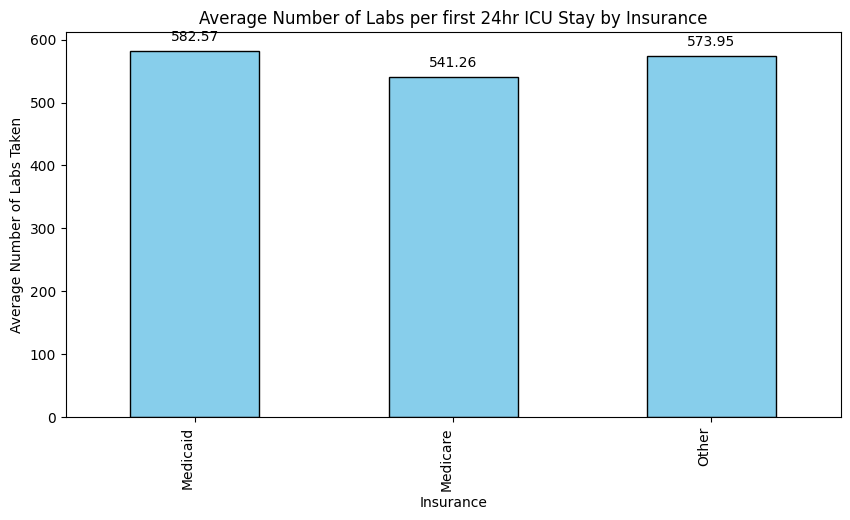

In [69]:
# Nhóm theo 'stay_id' và 'insurance' -> đếm số lượng sự kiện trong mỗi nhóm và lưu kết quả vào cột labs_count
average_labs = analysis_labs_df.groupby(['stay_id', 'insurance']).size().reset_index(name='labs_count').groupby('insurance')['labs_count'].mean()

# Biểu đồ thanh
ax = average_labs.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10, 5))

# thêm nhãn
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Labs per first 24hr ICU Stay by Insurance')
plt.xlabel('Insurance')
plt.ylabel('Average Number of Labs Taken')
# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

### (c) average number of vitals per ICU stay - số lượng trung bình các dấu hiệu sinh tồn trong mỗi lần nằm ICU

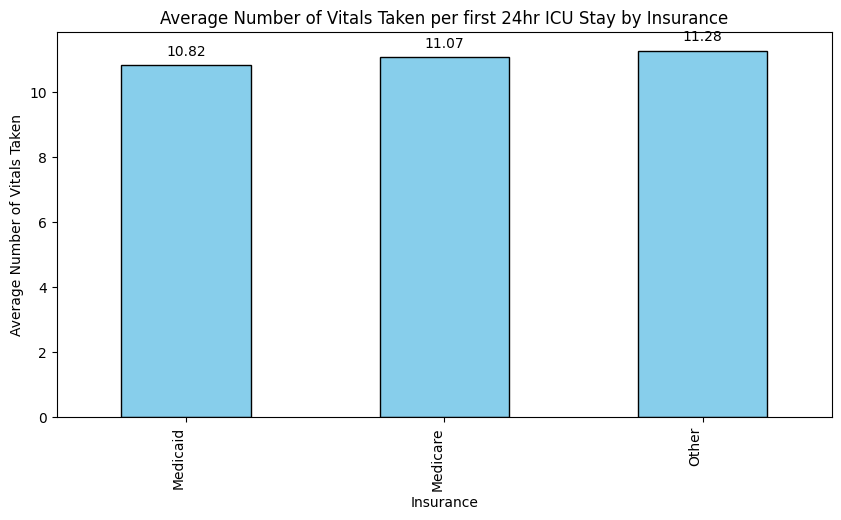

In [70]:
# Nhóm theo 'stay_id' và 'insurance' -> đếm số lượng sự kiện trong mỗi nhóm và lưu kết quả vào cột chartevents_count
average_chartevents = analysis_chartevents_df.groupby(['stay_id', 'insurance']).size().reset_index(name='chartevents_count').groupby('insurance')['chartevents_count'].mean()

# Biểu đồ thanh
ax = average_chartevents.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10, 5))

# them nhan
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Average Number of Vitals Taken per first 24hr ICU Stay by Insurance')
plt.xlabel('Insurance')
plt.ylabel('Average Number of Vitals Taken')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

## Fig. 4: Length of ICU Stay by Insurance and Race - Thời gian nằm ICU theo Bảo hiểm và Chủng tộc

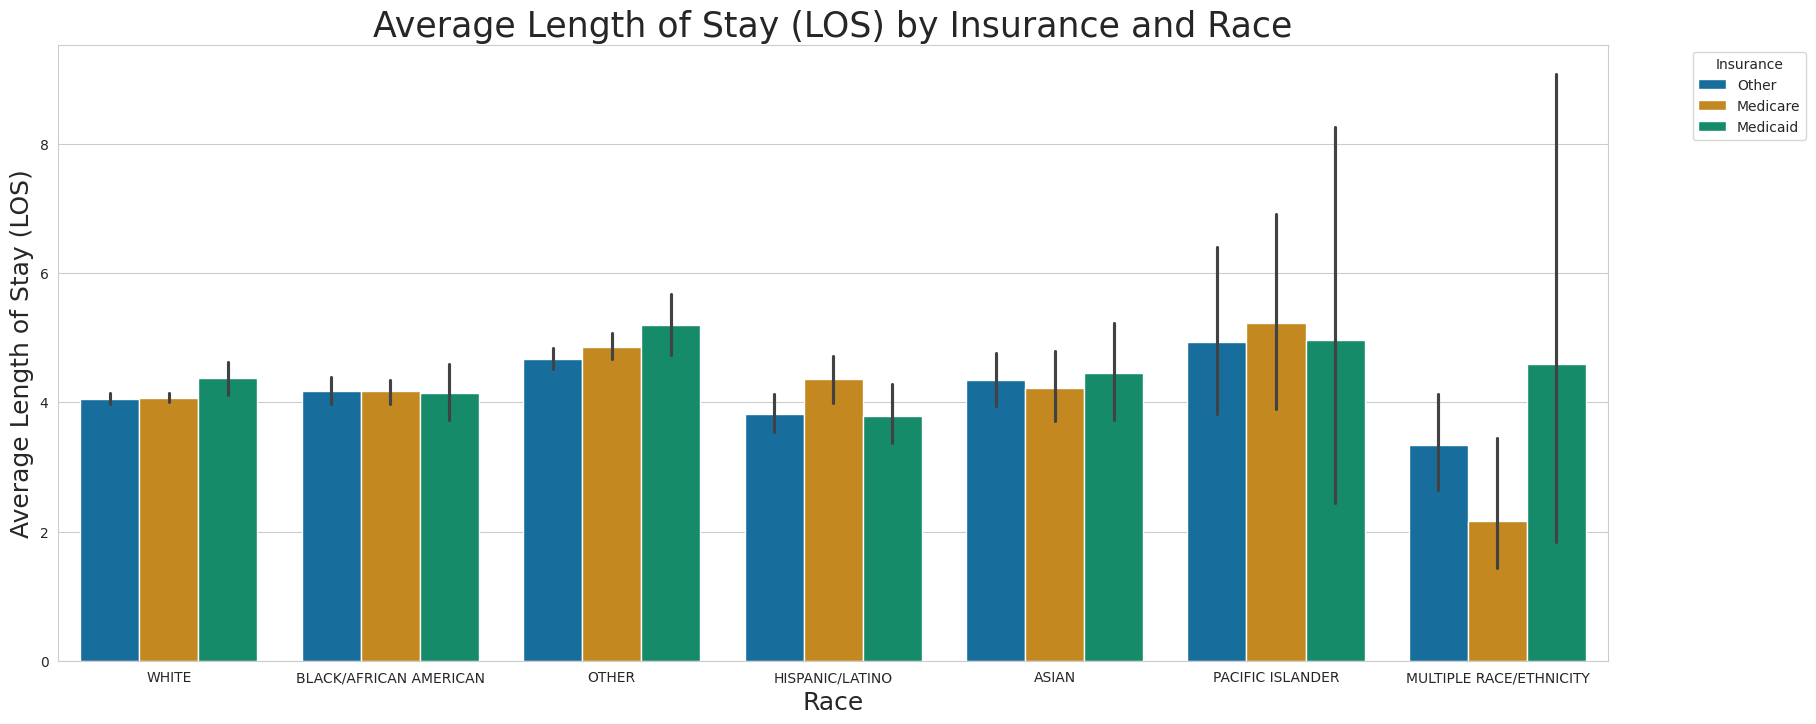

In [71]:
import seaborn as sns
# icu_data

# Đặt kiểu seaborn thành whitegrid
sns.set_style("whitegrid")

# Vẽ biểu đồ thanh nhóm cho LOS trung bình
plt.figure(figsize=(20, 8))
ax = sns.barplot(x='race', y='los', hue='insurance', data=icu_data, palette='colorblind', estimator=np.mean)

plt.title('Average Length of Stay (LOS) by Insurance and Race', fontsize = 25)
plt.xlabel('Race',fontsize = 18)
plt.ylabel('Average Length of Stay (LOS)', fontsize = 18)

plt.legend(title='Insurance', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

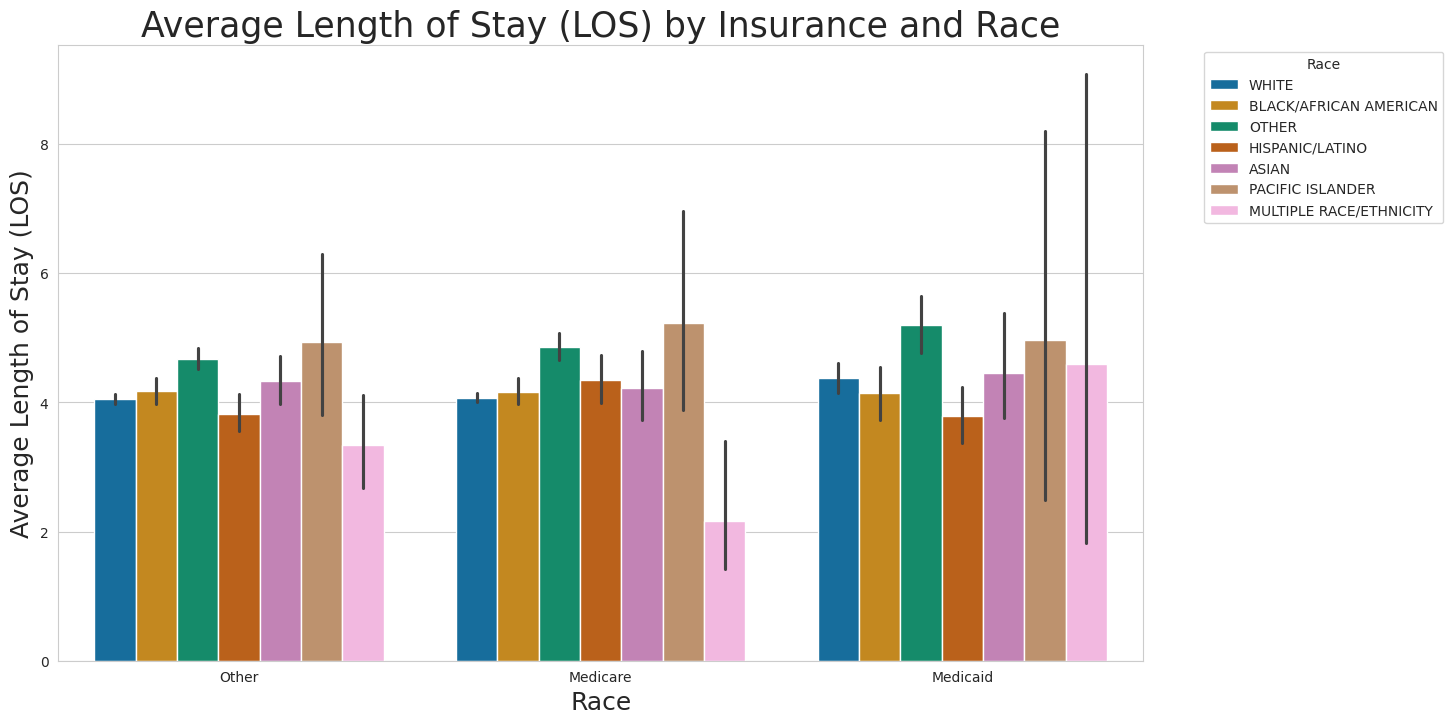

In [72]:
# Đặt kiểu seaborn thành whitegrid
sns.set_style("whitegrid")

# Vẽ biểu đồ thanh nhóm cho LOS trung bình cho insurance
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='insurance', y='los', hue='race', data=icu_data, palette='colorblind', estimator=np.mean)

plt.title('Average Length of Stay (LOS) by Insurance and Race', fontsize = 25)
plt.xlabel('Race', fontsize = 18)
plt.ylabel('Average Length of Stay (LOS)', fontsize = 18)

plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# ANOVA ANALYSIS

In [73]:
# tính trung bình thời gian nằm viện (los) cho mỗi nhóm
grouped_data = icu_data.groupby(['gender', 'insurance', 'race'])['los'].mean()


print(grouped_data)

gender  insurance  race                   
0       Medicaid   ASIAN                      4.195222
                   BLACK/AFRICAN AMERICAN     3.893657
                   HISPANIC/LATINO            3.948069
                   MULTIPLE RACE/ETHNICITY    6.815738
                   OTHER                      5.459344
                   PACIFIC ISLANDER           4.595108
                   WHITE                      4.185528
        Medicare   ASIAN                      4.543924
                   BLACK/AFRICAN AMERICAN     4.308302
                   HISPANIC/LATINO            4.403449
                   MULTIPLE RACE/ETHNICITY    3.338974
                   OTHER                      4.792551
                   PACIFIC ISLANDER           5.316365
                   WHITE                      4.190309
        Other      ASIAN                      4.731332
                   BLACK/AFRICAN AMERICAN     4.260432
                   HISPANIC/LATINO            3.767169
                   MUL

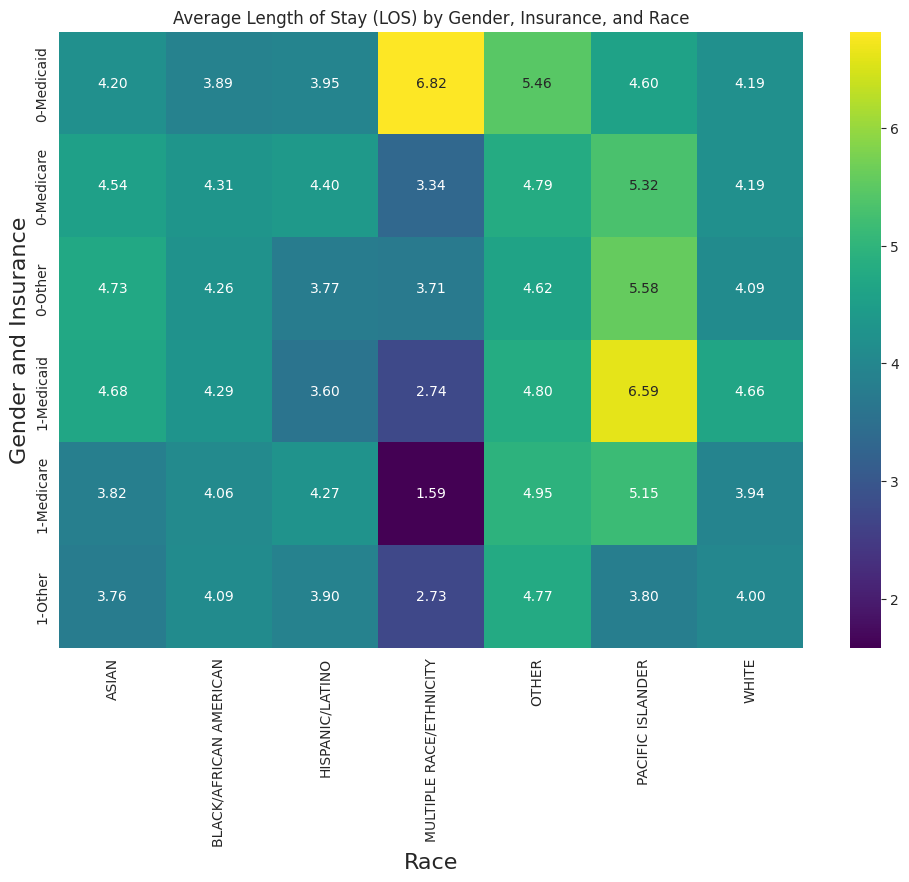

In [74]:
grouped_data = grouped_data.reset_index()

# Tạo bảng pivot để dễ dàng trực quan hóa
pivot_table = grouped_data.pivot_table(index=['gender', 'insurance'], columns='race', values='los')

# Vẽ bảng pivot dưới dạng biểu đồ nhiệt
plt.figure(figsize=(12, 8))
plt.title('Average Length of Stay (LOS) by Gender, Insurance, and Race')
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".2f")
plt.xlabel('Race', fontsize=16)
plt.ylabel('Gender and Insurance', fontsize=16)
plt.show()

In [75]:
from scipy.stats import f_oneway
# icu_data

# Thực hiện kiểm tra ANOVA một chiều cho 'gender'
anova_gender = f_oneway(*[group['los'].values for name, group in icu_data.groupby('gender')])

# Thực hiện kiểm tra ANOVA một chiều cho 'insurance'
anova_insurance = f_oneway(*[group['los'].values for name, group in icu_data.groupby('insurance')])

# Thực hiện kiểm tra ANOVA một chiều cho 'race'
anova_race = f_oneway(*[group['los'].values for name, group in icu_data.groupby('race')])

# in ra ket qua
print("ANOVA for Gender:")
print(anova_gender)

print("\nANOVA for Insurance:")
print(anova_insurance)

print("\nANOVA for Race:")
print(anova_race)


ANOVA for Gender:
F_onewayResult(statistic=9.384710259185336, pvalue=0.002189038185707358)

ANOVA for Insurance:
F_onewayResult(statistic=3.769883218111512, pvalue=0.023060455640155294)

ANOVA for Race:
F_onewayResult(statistic=22.11270216736019, pvalue=3.771858109994944e-26)


In [76]:
anova_results = {
    'Factor': ['Gender', 'Insurance', 'Race'],
    'F-Statistic': [
        anova_gender.statistic,
        anova_insurance.statistic,
        anova_race.statistic
    ],
    'p-Value': [
        anova_gender.pvalue,
        anova_insurance.pvalue,
        anova_race.pvalue
    ]
}

# Create a DataFrame from the dictionary
anova_summary = pd.DataFrame(anova_results)

# Print the summary table
print("\nANOVA Summary Table:")
anova_summary


ANOVA Summary Table:


,Factor,F-Statistic,p-Value
0,Gender,9.384710,2.189038e-03
1,Insurance,3.769883,2.306046e-02
2,Race,22.112702,3.771858e-26


# Model XGBOOST - Replication

In [77]:
condition = (icu_data['los'] > 4).map({True: 'Long', False: 'Short'})

# Tạo một cột mới 'los_type' dựa trên điều kiện
icu_data['los_type'] = condition

In [78]:
# Chia dữ liệu thành dữ liệu training  và dữ liệu validation
from sklearn.model_selection import train_test_split

# Giả sử 'subject_id' là mã định danh bệnh nhân
patient_ids = icu_data['subject_id'].unique()

# Chia patient_ids thành các tập huấn luyện và thử nghiệm
train_patient_ids, validation_patient_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)

# Lọc khung dữ liệu dựa trên sự phân chia của patient_ids
train_data = icu_data[icu_data['subject_id'].isin(train_patient_ids)]
validation_data = icu_data[icu_data['subject_id'].isin(validation_patient_ids)]

# Kiểm tra hình dạng của tập huấn luyện và tập kiểm tra
print("Training set shape:", train_data.shape)
print("Validation set shape:", validation_data.shape)

Training set shape: (45901, 5075)
Validation set shape: (11586, 5075)


In [79]:
# Đếm số lượng các giá trị khác nhau trong cột 'insurance' ở tập train
train_insurance_counts =train_data['insurance'].value_counts()
print("\033[1mTrain Data Insurance Counts\033[0m:")
print(train_insurance_counts)
print()

# Đếm số lượng các giá trị khác nhau trong cột 'insurance' ở test
validation_insurance_counts =validation_data['insurance'].value_counts()
print("\033[1mValidation Data Insurance Counts:\033[0m")
print(validation_insurance_counts)
print()

# Đếm số lượng các giá trị khác nhau trong cột 'race'
train_race_counts =train_data['race'].value_counts()
print("\033[1mTrain Data Race Counts:\033[0m")
print(train_race_counts)
print()

# Đếm số lượng các giá trị khác nhau trong cột 'race'
validation_race_counts =validation_data['race'].value_counts()
print("\033[1mValidation Data Race Counts:\033[0m")
print(validation_race_counts)
print()

# Đếm số lượng các giá trị khác nhau trong cột 'los_type'
train_duration_counts =train_data['los_type'].value_counts()
print("\033[1mTrain Data LOS Counts:\033[0m")
print(train_duration_counts)
print()

# Đếm số lượng các giá trị khác nhau trong cột 'los_type'
validation_duration_counts =validation_data['los_type'].value_counts()
print("\033[1mValidation Data LOS Counts:\033[0m")
print(validation_duration_counts)

Train Data Insurance Counts:
insurance
Other       21567
Medicare    21039
Medicaid     3295
Name: count, dtype: int64

Validation Data Insurance Counts:
insurance
Other       5393
Medicare    5300
Medicaid     893
Name: count, dtype: int64

Train Data Race Counts:
race
WHITE                      31432
OTHER                       6522
BLACK/AFRICAN AMERICAN      4688
HISPANIC/LATINO             1731
ASIAN                       1335
PACIFIC ISLANDER             148
MULTIPLE RACE/ETHNICITY       45
Name: count, dtype: int64

Validation Data Race Counts:
race
WHITE                      7861
OTHER                      1608
BLACK/AFRICAN AMERICAN     1284
HISPANIC/LATINO             423
ASIAN                       355
PACIFIC ISLANDER             48
MULTIPLE RACE/ETHNICITY       7
Name: count, dtype: int64

Train Data LOS Counts:
los_type
Short    32710
Long     13191
Name: count, dtype: int64

Validation Data LOS Counts:
los_type
Short    8302
Long     3284
Name: count, dtype: int64


In [80]:
# lấy cột subject_id duy nhất
patient_ids_train = train_data['subject_id'].unique()

# Chia patient_ids_train thành các tập huấn luyện và thử nghiệm
train_train_ids, test_train_ids = train_test_split(patient_ids_train, test_size=0.2, random_state=42)

# Lọc train_data dựa trên sự phân chia của patient_ids_train
train_train_data = train_data[train_data['subject_id'].isin(train_train_ids)]
test_train_data = train_data[train_data['subject_id'].isin(test_train_ids)]

# Kiểm tra hình dạng của tập huấn luyện và tập kiểm tra
print("Train Training set shape:", train_train_data.shape)
print("Train Testing set shape:", test_train_data.shape)

Train Training set shape: (36738, 5075)
Train Testing set shape: (9163, 5075)


# 1, XGBoost trên tập train_train_data và test_train_data

In [81]:
train_train_data

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,age,gender,...,zanamivir,zeas,zileuton,zinc oxide,zinc oxide-white petrolatum,zolmitriptan,zonisamide,zydis,zz,los_type
0,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,55,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Short
2,10001884,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,77,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Long
3,10002013,23581541,39060235,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,57,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Short
6,10002223,22494570,39638202,Trauma SICU (TSICU),Trauma SICU (TSICU),2158-01-15 08:01:49,2158-01-16 15:19:24,1.303877,21,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Short
12,10002430,26295318,38392119,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2129-06-13 00:43:08,2129-06-15 22:51:40,2.922593,90,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57476,19998330,24492004,32641669,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2178-10-01 08:51:00,2178-10-03 23:25:08,2.607037,72,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Short
57482,19999297,21439025,37364566,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2162-08-16 05:48:32,2162-08-23 06:22:41,7.023715,42,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Long
57483,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19 14:23:43,2148-11-26 13:12:15,6.950370,43,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Long
57484,19999828,25744818,36075953,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,48,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Short


In [82]:
test_train_data

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,age,gender,...,zanamivir,zeas,zileuton,zinc oxide,zinc oxide-white petrolatum,zolmitriptan,zonisamide,zydis,zz,los_type
7,10002348,22725460,32610785,Neuro Intermediate,Neuro Intermediate,2112-11-30 23:24:00,2112-12-10 18:25:13,9.792512,77,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Long
13,10002443,21329021,35044219,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2183-10-18 00:47:00,2183-10-20 18:48:03,2.750729,53,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Short
14,10002495,24982426,36753294,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2141-05-22 20:18:01,2141-05-27 22:24:02,5.087512,81,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Long
15,10002527,29112696,37121704,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2136-03-24 10:24:08,2136-03-25 20:55:36,1.438519,50,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Short
33,10004457,23251352,31494479,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2141-12-17 10:24:25,2141-12-18 14:16:17,1.161019,66,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57430,19992885,25491636,35108564,Trauma SICU (TSICU),Trauma SICU (TSICU),2152-06-23 13:36:04,2152-06-25 17:22:46,2.157431,50,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Short
57431,19992885,25491636,37690347,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2152-06-20 09:13:00,2152-06-21 18:07:38,1.371273,50,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Short
57451,19995244,27127412,37684913,Neuro Intermediate,Neuro Intermediate,2111-01-11 23:11:50,2111-01-14 00:17:36,2.045671,80,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Short
57479,19998843,24842066,30988867,Trauma SICU (TSICU),Trauma SICU (TSICU),2187-02-05 10:12:00,2187-02-08 18:19:39,3.338646,45,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Short


In [83]:
!pip install xgboost
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Các cột cần loại trừ khỏi các tính năng
exclude_columns = ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los', 'los_type', 
                   'age', 'gender', 'insurance', 'race', 'PHYSICIAN REFERRAL']

# Xác định các cột tính năng của bạn (loại trừ các cột nhất định)
feature_columns = [col for col in train_data.columns if col not in exclude_columns]

# Loại trừ các cột không phải số trước khi chia tỷ lệ
numeric_columns = train_train_data[feature_columns].select_dtypes(include=['float64', 'int64']).columns
X_train = train_train_data[numeric_columns]
y_train = train_train_data['los_type']
X_test = test_train_data[numeric_columns]
y_test = test_train_data['los_type']

# Chuyển đổi 'Short' và 'Long' thành số (0 và 1)
y_train = y_train.map({'Short': 0, 'Long': 1})
y_test = y_test.map({'Short': 0, 'Long': 1})

# Chuẩn hóa các tính năng nếu cần (tùy chọn nhưng thường có lợi)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#  Tạo  XGBoost classifier
model = XGBClassifier(objective='binary:logistic', random_state=42)

# Huấn luyện mô hình
model.fit(X_train, y_train)

# Đưa ra dự đoán trên tập kiểm tra
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Chuyển đổi điểm xác suất thành dự đoán nhị phân bằng cách sử dụng ngưỡng
threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)

# Tạo đường cong ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Tạo đường cong độ chính xác-thu hồi
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 2.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


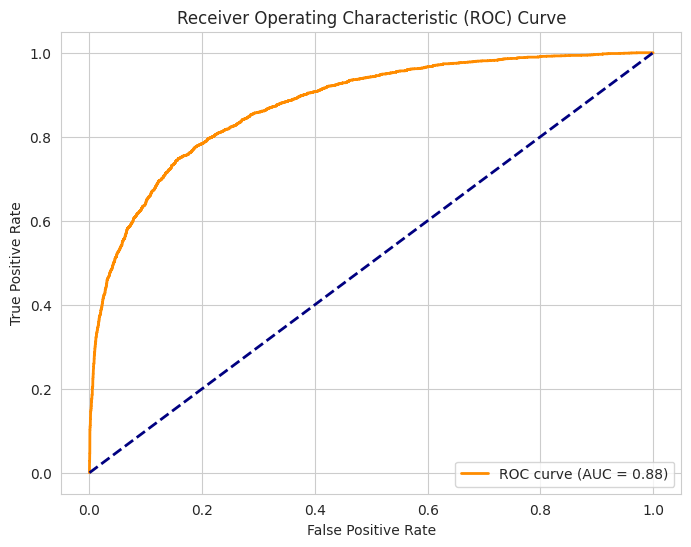

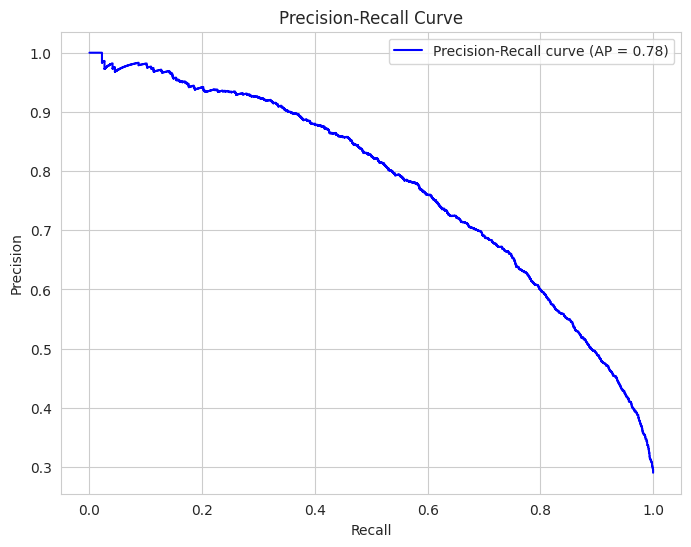

Area under ROC curve (AUC-ROC): 0.88
Area under Precision-Recall curve (AUC-PR): 0.78
Confusion Matrix:
[[6010  494]
 [1073 1586]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      6504
           1       0.76      0.60      0.67      2659

    accuracy                           0.83      9163
   macro avg       0.81      0.76      0.78      9163
weighted avg       0.82      0.83      0.82      9163



In [84]:
# Vẽ đường cong ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Vẽ đường cong độ chính xác-thu hồi
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', where='post', label='Precision-Recall curve (AP = {:.2f})'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()
print(f'Area under ROC curve (AUC-ROC): {roc_auc:.2f}')
print(f'Area under Precision-Recall curve (AUC-PR): {average_precision:.2f}')

# Tạo ma trận nhầm lẫn và báo cáo phân loại
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(cr)


## 1.1, Insurance - Bảo hiểm

In [85]:
# Các cột cần loại trừ khỏi các tính năng
exclude_columns = ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los', 'los_type', 
                   'age', 'gender', 'insurance', 'race', 'PHYSICIAN REFERRAL']

# Xác định các cột tính năng của bạn (loại trừ các cột nhất định)
feature_columns = [col for col in train_data.columns if col not in exclude_columns]

# Loại trừ các cột không phải số trước khi chia tỷ lệ
numeric_columns = train_train_data[feature_columns].select_dtypes(include=['float64', 'int64']).columns
X_train = train_train_data[numeric_columns]
y_train = train_train_data['los_type']
X_test = test_train_data[numeric_columns]
y_test = test_train_data['los_type']


# Chuyển đổi 'Short' và 'Long' thành số (0 và 1)
y_train = y_train.map({'Short': 0, 'Long': 1})
y_test = y_test.map({'Short': 0, 'Long': 1})

# Chuẩn hóa các feature nếu cần (tùy chọn nhưng thường có lợi)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# # Trích xuất thông tin bảo hiểm cho test set
insurance_test = train_data.loc[y_test.index, 'insurance']

# # Tạo XGBoost 
model = XGBClassifier(objective='binary:logistic', random_state=42)

# Huấn luyện model
model.fit(X_train, y_train)

# Đưa ra dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Kết hợp thông tin dự đoán và bảo hiểm vào một DataFrame
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Insurance': insurance_test})

# Đánh giá hiệu suất cho từng loại bảo hiểm
insurance_types = results_df['Insurance'].unique()

for insurance_type in insurance_types:
    subset = results_df[results_df['Insurance'] == insurance_type]
    
    # Tạo ma trận nhầm lẫn và báo cáo phân loại
    cm = confusion_matrix(subset['Actual'], subset['Predicted'])
    cr = classification_report(subset['Actual'], subset['Predicted'])
    
    print(f"Results for {insurance_type} insurance:")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(cr)
    print('\n' + '-'*50 + '\n')

Results for Medicare insurance:
Confusion Matrix:
[[2752  233]
 [ 529  743]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      2985
           1       0.76      0.58      0.66      1272

    accuracy                           0.82      4257
   macro avg       0.80      0.75      0.77      4257
weighted avg       0.82      0.82      0.81      4257


--------------------------------------------------

Results for Other insurance:
Confusion Matrix:
[[2833  223]
 [ 477  702]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      3056
           1       0.76      0.60      0.67      1179

    accuracy                           0.83      4235
   macro avg       0.81      0.76      0.78      4235
weighted avg       0.83      0.83      0.83      4235


--------------------------------------------------

Results for Medicaid insurance:
Confusion

## 1.2, Race - chủng tộc

In [86]:
# Các cột cần loại trừ khỏi các tính năng
exclude_columns = ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los', 'los_type', 
                   'age', 'gender', 'insurance', 'race', 'PHYSICIAN REFERRAL']

# Xác định các cột tính năng của bạn (loại trừ các cột nhất định)
feature_columns = [col for col in train_data.columns if col not in exclude_columns]

# Loại trừ các cột không phải số trước khi chia tỷ lệ
numeric_columns = train_train_data[feature_columns].select_dtypes(include=['float64', 'int64']).columns
X_train = train_train_data[numeric_columns]
y_train = train_train_data['los_type']
X_test = test_train_data[numeric_columns]
y_test = test_train_data['los_type']

# Chuyển đổi 'Short' và 'Long' thành nhãn số (0 và 1)
y_train = y_train.map({'Short': 0, 'Long': 1})
y_test = y_test.map({'Short': 0, 'Long': 1})

# Chuẩn hóa các tính năng nếu cần (tùy chọn nhưng thường có lợi)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Trích xuất thông tin chủng tộc cho bộ kiểm tra
race_test = train_data.loc[y_test.index, 'race']

# tạo XGBoost classifier
model = XGBClassifier(objective='binary:logistic', random_state=42)

# Huấn luyện model
model.fit(X_train, y_train)

# Đưa ra dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

#  Kết hợp thông tin dự đoán và chủng tộc vào một DataFrame
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Race': race_test})

# Tạo bảng chứa cột chủng tộc duy nhất 
race_types = results_df['Race'].unique()

# Đánh giá hiệu suất cho từng loại chủng tộc
for race_type in race_types:
    subset = results_df[results_df['Race'] == race_type]
    
    # Tạo ma trận nhầm lẫn và báo cáo phân loại
    cm = confusion_matrix(subset['Actual'], subset['Predicted'])
    cr = classification_report(subset['Actual'], subset['Predicted'])
    
    print(f"Results for {race_type} race:")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(cr)
    print('\n' + '-'*50 + '\n')


Results for WHITE race:
Confusion Matrix:
[[4197  320]
 [ 744 1001]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4517
           1       0.76      0.57      0.65      1745

    accuracy                           0.83      6262
   macro avg       0.80      0.75      0.77      6262
weighted avg       0.82      0.83      0.82      6262


--------------------------------------------------

Results for OTHER race:
Confusion Matrix:
[[767  91]
 [128 290]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       858
           1       0.76      0.69      0.73       418

    accuracy                           0.83      1276
   macro avg       0.81      0.79      0.80      1276
weighted avg       0.83      0.83      0.83      1276


--------------------------------------------------

Results for BLACK/AFRICAN AMERICAN race:
Confusion Matrix:

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


# Đánh giá sự công bằng trong các mô hình học máy

In [87]:
#  tính toán sự khác biệt về tỷ lệ dương tính thật 
# (True Positive Rate - TPR) và tỷ lệ dương tính giả (False Positive Rate - FPR)
def equalized_odds(y_true, y_pred, sensitive_feature):
    # Tính toán ma trận nhầm lẫn
    cm_protected = confusion_matrix(y_true[sensitive_feature], y_pred[sensitive_feature])
    cm_non_protected = confusion_matrix(y_true[~sensitive_feature], y_pred[~sensitive_feature])

    # Tính tỷ lệ dương tính thật (độ nhạy) và tỷ lệ dương tính giả (rò rỉ) cho cả hai nhóm
    tpr_protected = cm_protected[1, 1] / cm_protected.sum(axis=1)[1]
    fpr_protected = cm_protected[0, 1] / cm_protected.sum(axis=1)[0]

    tpr_non_protected = cm_non_protected[1, 1] / cm_non_protected.sum(axis=1)[1]
    fpr_non_protected = cm_non_protected[0, 1] / cm_non_protected.sum(axis=1)[0]

    # Tính toán sự khác biệt tuyệt đối về TPR và FPR giữa nhóm được bảo vệ và nhóm không được bảo vệ
    tpr_difference = abs(tpr_protected - tpr_non_protected)
    fpr_difference = abs(fpr_protected - fpr_non_protected)

    return tpr_difference + fpr_difference

# Tính toán sự khác biệt về tỷ lệ dự đoán dương tính
def demographic_parity(y_pred, sensitive_feature):
    proportion_protected = y_pred[sensitive_feature].mean()
    proportion_non_protected = y_pred[~sensitive_feature].mean()

    return abs(proportion_protected - proportion_non_protected)

# 2, XGBoost trên tập validation

In [88]:
# validation_data = icu_data[icu_data['subject_id'].isin(validation_patient_ids)]
validation_data

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,age,gender,...,zanamivir,zeas,zileuton,zinc oxide,zinc oxide-white petrolatum,zolmitriptan,zonisamide,zydis,zz,los_type
1,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,46,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Short
4,10002155,23822395,33685454,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2129-08-04 12:45:00,2129-08-10 17:02:38,6.178912,81,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Long
5,10002155,28994087,31090461,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2130-09-24 00:50:00,2130-09-27 22:13:41,3.891447,82,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Short
8,10002428,20321825,34807493,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2156-04-30 21:53:00,2156-05-02 22:27:20,2.023843,81,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Short
9,10002428,23473524,35479615,Surgical Intensive Care Unit (SICU),Medical Intensive Care Unit (MICU),2156-05-11 14:49:34,2156-05-22 14:16:46,10.977222,81,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Long
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57463,19997293,28847872,31877557,Medical Intensive Care Unit (MICU),Coronary Care Unit (CCU),2123-12-29 01:48:04,2124-01-03 23:16:34,5.894792,76,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Long
57477,19998591,24349193,31144045,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2185-07-16 18:48:18,2185-07-26 18:27:01,9.985220,53,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Long
57478,19998591,24349193,36794489,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2185-07-03 22:45:00,2185-07-12 13:40:34,8.621921,53,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Long
57480,19999287,20175828,35165301,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2197-08-04 00:02:00,2197-08-08 16:58:17,4.705752,77,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Long


In [89]:
# Các cột cần loại trừ khỏi các tính năng
exclude_columns = ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los', 'los_type', 
                   'age', 'gender', 'insurance', 'race', 'PHYSICIAN REFERRAL']

# Xác định các cột tính năng của bạn (loại trừ các cột nhất định)
feature_columns = [col for col in validation_data.columns if col not in exclude_columns]

# Loại trừ các cột không phải số trước khi chia tỷ lệ
numeric_columns = validation_data[feature_columns].select_dtypes(include=['float64', 'int64']).columns
X_verify = validation_data[numeric_columns]
y_verify = validation_data['los_type']

# Chuyển đổi 'Short' và 'Long' thành nhãn số (0 và 1)
y_verify = y_verify.map({'Short': 0, 'Long': 1})

# Chuẩn hóa các tính năng bằng cách sử dụng cùng một bộ chia tỷ lệ từ tập huấn luyện
X_verify = scaler.transform(X_verify)

# Đưa ra dự đoán về tập xác minh bằng cách sử dụng mô hình hiện có
y_verify_pred_prob = model.predict_proba(X_verify)[:, 1]

# Chuyển đổi điểm xác suất thành dự đoán nhị phân bằng cách sử dụng ngưỡng
y_verify_pred = (y_verify_pred_prob > threshold).astype(int)

# Tạo đường cong ROC cho tập xác minh
fpr_verify, tpr_verify, thresholds_verify = roc_curve(y_verify, y_verify_pred_prob)
roc_auc_verify = auc(fpr_verify, tpr_verify)

# Tạo đường cong độ chính xác-thu hồi cho tập xác minh
precision_verify, recall_verify, _ = precision_recall_curve(y_verify, y_verify_pred_prob)
average_precision_verify = average_precision_score(y_verify, y_verify_pred_prob)

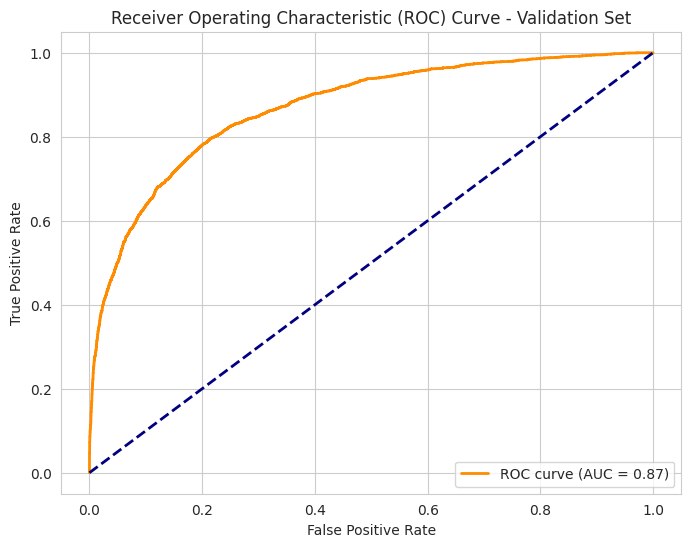

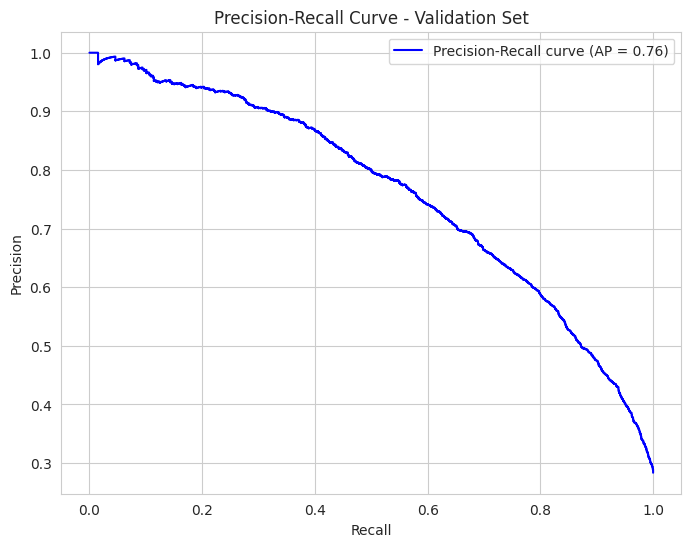

Area under ROC curve (AUC-ROC) for Verification Set: 0.87
Area under Precision-Recall curve (AUC-PR) for Verification Set: 0.76
Confusion Matrix for Test Set:
[[7622  680]
 [1324 1960]]

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      8302
           1       0.74      0.60      0.66      3284

    accuracy                           0.83     11586
   macro avg       0.80      0.76      0.77     11586
weighted avg       0.82      0.83      0.82     11586



In [90]:
# Vẽ đường cong ROC cho tập xác minh
plt.figure(figsize=(8, 6))
plt.plot(fpr_verify, tpr_verify, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_verify))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation Set')
plt.legend(loc='lower right')
plt.show()

# Vẽ đường cong độ chính xác-thu hồi cho tập xác minh
plt.figure(figsize=(8, 6))
plt.step(recall_verify, precision_verify, color='b', where='post', label='Precision-Recall curve (AP = {:.2f})'.format(average_precision_verify))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Validation Set')
plt.legend(loc='upper right')
plt.show()

print(f'Area under ROC curve (AUC-ROC) for Verification Set: {roc_auc_verify:.2f}')
print(f'Area under Precision-Recall curve (AUC-PR) for Verification Set: {average_precision_verify:.2f}')


# Tạo ma trận nhầm lẫn và báo cáo phân loại cho tập xác minh
cm_verify = confusion_matrix(y_verify, y_verify_pred)
cr_verify = classification_report(y_verify, y_verify_pred)

print("Confusion Matrix for Test Set:")
print(cm_verify)

print("\nClassification Report for Test Set:")
print(cr_verify)

In [91]:
print("\nClassification Report for Test Set:")
print(cr_verify)


Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      8302
           1       0.74      0.60      0.66      3284

    accuracy                           0.83     11586
   macro avg       0.80      0.76      0.77     11586
weighted avg       0.82      0.83      0.82     11586



In [92]:
print("Confusion Matrix for Test Set:")
cm_verify

Confusion Matrix for Test Set:


array([[7622,  680],
       [1324, 1960]])

In [93]:
import numpy as np
y_true = validation_data['los_type'].map({'Short': 0, 'Long': 1})

# 'validation_data' có các dự đoán được lưu trữ trong 'y_verify_pred'
cm_verify = confusion_matrix(y_true, y_verify_pred)

# Trích xuất các giá trị từ ma trận nhầm lẫn
tn, fp, fn, tp = cm_verify.ravel()

#  Tính toán tỷ lệ cược cân bằng
equalized_odds_race = (tp / (tp + fn)) / (fp / (fp + tn))

print(equalized_odds_race)

7.286630364691551


## Insurance

In [94]:

exclude_columns = ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los', 'los_type', 
                   'age', 'gender', 'race', 'PHYSICIAN REFERRAL']


feature_columns = [col for col in validation_data.columns if col not in exclude_columns]

# Loại trừ các cột không phải số trước khi chia tỷ lệ
numeric_columns = validation_data[feature_columns].select_dtypes(include=['float64', 'int64']).columns
X = validation_data[numeric_columns]
y = validation_data['los_type']


y = y.map({'Short': 0, 'Long': 1})


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trích xuất thông tin bảo hiểm cho bộ kiểm tra
insurance_test = validation_data.loc[y_test.index, 'insurance']


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model = XGBClassifier(objective='binary:logistic', random_state=42)


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Insurance': insurance_test})

# Đánh giá hiệu suất cho từng loại bảo hiểm
insurance_types = results_df['Insurance'].unique()

for insurance_type in insurance_types:
    subset = results_df[results_df['Insurance'] == insurance_type]
    
    # Tạo ma trận nhầm lẫn và báo cáo phân loại
    cm = confusion_matrix(subset['Actual'], subset['Predicted'])
    cr = classification_report(subset['Actual'], subset['Predicted'])
    
    print(f"Results for {insurance_type} insurance:")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(cr)
    print('\n' + '-'*50 + '\n')
    
    # Calculate Type 1 and Type 2 errors
    type1_error = cm[0, 1]  # False Positives
    type2_error = cm[1, 0]  # False Negatives

    print(f"Type 1 Error (False Positives): {type1_error}")
    print(f"Type 2 Error (False Negatives): {type2_error}")

    print('\n' + '-'*50 + '\n')

Results for Medicare insurance:
Confusion Matrix:
[[667  64]
 [147 179]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       731
           1       0.74      0.55      0.63       326

    accuracy                           0.80      1057
   macro avg       0.78      0.73      0.75      1057
weighted avg       0.79      0.80      0.79      1057


--------------------------------------------------

Type 1 Error (False Positives): 64
Type 2 Error (False Negatives): 147

--------------------------------------------------

Results for Other insurance:
Confusion Matrix:
[[723  48]
 [135 169]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       771
           1       0.78      0.56      0.65       304

    accuracy                           0.83      1075
   macro avg       0.81      0.75      0.77      1075
weighted avg       0.82      0.83

## Race

In [95]:

exclude_columns = ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los', 'los_type', 
                   'age', 'gender', 'race', 'PHYSICIAN REFERRAL']


feature_columns = [col for col in validation_data.columns if col not in exclude_columns]

# Loại trừ các cột không phải số trước khi chia tỷ lệ
numeric_columns = validation_data[feature_columns].select_dtypes(include=['float64', 'int64']).columns
X = validation_data[numeric_columns]
y = validation_data['los_type']

# Chuyển đổi 'Ngắn' và 'Dài' thành nhãn số (0 và 1)
y = y.map({'Short': 0, 'Long': 1})


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


race_test = validation_data.loc[y_test.index, 'race']


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model = XGBClassifier(objective='binary:logistic', random_state=42)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)


results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Race': race_test})

# Đánh giá hiệu suất cho từng loại
for race_type in race_types:
    subset = results_df[results_df['Race'] == race_type]
    
    # Tạo ma trận nhầm lẫn và báo cáo phân loại
    cm = confusion_matrix(subset['Actual'], subset['Predicted'])
    cr = classification_report(subset['Actual'], subset['Predicted'])
    
    print(f"Results for {race_type} race:")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(cr)
    print('\n' + '-'*50 + '\n')

Results for WHITE race:
Confusion Matrix:
[[1056   86]
 [ 201  242]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1142
           1       0.74      0.55      0.63       443

    accuracy                           0.82      1585
   macro avg       0.79      0.74      0.75      1585
weighted avg       0.81      0.82      0.81      1585


--------------------------------------------------

Results for OTHER race:
Confusion Matrix:
[[189  18]
 [ 42  71]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       207
           1       0.80      0.63      0.70       113

    accuracy                           0.81       320
   macro avg       0.81      0.77      0.78       320
weighted avg       0.81      0.81      0.81       320


--------------------------------------------------

Results for BLACK/AFRICAN AMERICAN race:
Confusion Matrix:

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
